# Analysis The Best Service Plan in Telecom Operator Megaline

*Analyst : Ica Candra Rambadiana*

*December, 2022*

<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1</b> <a class="tocSkip"></a>

Dear code reviewer,
I'm Ica. I'm a newly transferred student here. First, I apologize for my late submission. I struggled to catch up with the course material since I couldn't access the platform during the transfer process. 
I wish to get suggestions and any input for my work, both on my codes and the way I explained the results. Since I'm not fluent enough in English.

Thank you,
Your concern is my honor
Ica Candra Rambadiana
</div>

The telecom operator Megaline company offers two prepaid plans for its clients, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue to adjust the advertising budget.

In this notebook, we carried out a preliminary analysis of the plans based on a relatively small client selection. We had the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages that the users sent in 2018. 

The objective of this analysis is to analyze the clients' behavior and determine which prepaid plan brings in more revenue. 

Here are several steps which are conducted through the analysis:
- Preparing and enriching the dataset
- Aggregating dataset from several relevant data
- Analyzing the users' behavior based on plan types
- Statistical Test: Comparing the average revenue from both plans

## Initialization

In [1]:
# Loading all the libraries

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import math as mt

from scipy import stats as st
from warnings import filterwarnings
filterwarnings('ignore')

import calendar
import seaborn as sns
sns.set()


## Load data

In [86]:
# Load the dataset into different DataFrames

try: 
    call = pd.read_csv('/datasets/megaline_calls.csv')
    internet = pd.read_csv('/datasets/megaline_internet.csv')
    msg = pd.read_csv('/datasets/megaline_messages.csv')
    plan = pd.read_csv('/datasets/megaline_plans.csv')
    user = pd.read_csv('/datasets/megaline_users.csv')
except :
    call = pd.read_csv('content/megaline_calls.csv')
    internet = pd.read_csv('content/megaline_internet.csv')
    msg = pd.read_csv('content/megaline_messages.csv')
    plan = pd.read_csv('content/megaline_plans.csv')
    user = pd.read_csv('content/megaline_users.csv')

## Prepare the data

Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

### Plans

The plans table description.

- `plan_name` — calling plan name
- `usd_monthly_fee` — monthly charge in US dollars
- `minutes_included` — monthly minute allowance
- `messages_included` — monthly text allowance
- `mb_per_month_included` — data volume allowance (in megabytes)
- `usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- `usd_per_message` — price per text after exceeding the package limits
- `usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

In [3]:
# Print the general/summary information about the plans' DataFrame

plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# check duplicates

plan.duplicated().sum()

0

In [5]:
# Print a sample of data for plans

plan

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate

**Findings:**
* Plan dataset is clean
* Duplicates aren't detected
* Dtypes have already appropriated




### Enrinch Data

In [6]:
# convert mb to gb in new column
plan['gb_per_month_included'] = (plan['mb_per_month_included']/1024).astype('int')

In [7]:
# rename and arrange dataset
plan = (plan.set_axis(
    ['msg_plan', 'mb_plan', 'minutes_plan',
     'usd_month', 'usd_per_gb', 'usd_per_msg',
     'usd_per_minute','plan_name', 'gb_plan'],
    axis=1
))

# reorder columns for convenience
plan = plan[['plan_name', 'usd_month',
             'minutes_plan', 'usd_per_minute',
             'msg_plan', 'usd_per_msg',
             'mb_plan', 'gb_plan', 'usd_per_gb'
        ]]

plan

plan_name  usd_month  minutes_plan  usd_per_minute  msg_plan  usd_per_msg  \
0      surf         20           500            0.03        50         0.03   
1  ultimate         70          3000            0.01      1000         0.01   

   mb_plan  gb_plan  usd_per_gb  
0    15360       15          10  
1    30720       30           7

### Users

The users table description.

- `user_id` — unique user identifier
- `first_name` — user's name
- `last_name` — user's last name
- `age` — user's age (years)
- `reg_date` — subscription date (dd, mm, yy)
- `churn_date` — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- `city` — user's city of residence
- `plan` — calling plan name

In [8]:
# Print the general/summary information about the user

user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# check duplicates

user.duplicated().sum()

0

In [10]:
# Print a sample of data for users

user.sample(3)

user_id first_name last_name  age  \
252     1252     Mitsue      York   27   
448     1448     Elayne     Foley   33   
113     1113    Spencer    Powers   27   

                                          city    reg_date      plan  \
252            Detroit-Warren-Dearborn, MI MSA  2018-06-10      surf   
448                     Urban Honolulu, HI MSA  2018-10-17      surf   
113  New York-Newark-Jersey City, NY-NJ-PA MSA  2018-06-04  ultimate   

    churn_date  
252        NaN  
448        NaN  
113        NaN

In [11]:
# check data description

user.describe()

user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000

**Findings:**
* Dtype in`reg_date` and `churn_date` columns aren't `DateTime`
* Missing values appear in column `churn_date` due to the service plan being used when this database was extracted
* No duplicates in all datasets
* There's no suspicious value

#### Fix Data

In [12]:
# change dtype in 'reg_date' and 'churn_date'

date_format = '%Y-%m-%d'

user['reg_date'] = pd.to_datetime(user['reg_date'], format=date_format)
user['churn_date'] = pd.to_datetime(user['churn_date'], format=date_format)

### Calls

The calls table description.

- `id` — unique call identifier
- `call_date` — call date
- `duration` — call duration (in minutes)
- `user_id` — the identifier of the user making the call

*Note: Megaline rounds seconds up to minutes. Each individual call is rounded up. If the call lasted just one second, It will be counted as one minute.*

In [13]:
# Print the general/summary information about the calls' DataFrame

call.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [14]:
# check duplicates

call.duplicated().sum()

0

In [15]:
# Print a sample of data for calls

call.sample(3)

id  user_id   call_date  duration
122443   1433_14     1433  2018-11-11      1.10
113601  1399_224     1399  2018-11-12      7.78
110930  1390_379     1390  2018-09-02     13.73

In [16]:
# check data description

call.describe()

user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000

**Findings:**
* Dtype in the `call_date` column isn't in the `DateTime`
* Duplicates aren't detected
* Call dataset is clean
* There's no suspicious value

#### Fix data

In [17]:
# change dtype in `call_date`

call['call_date'] = pd.to_datetime(call['call_date'], format=date_format)

#### Enrich data

In [18]:
# add 'call_month'
call['month'] = call['call_date'].dt.strftime("%b")

# add `round_duration`
call['round_duration'] = call['duration'].apply(lambda x : mt.ceil(x))

# check the result
call.sample(3)

id  user_id  call_date  duration month  round_duration
4238   1017_212     1017 2018-09-20      8.63   Sep               9
79821  1285_346     1285 2018-09-02      6.99   Sep               7
1098   1007_119     1007 2018-09-13      4.85   Sep               5

In [19]:
# create call_monthly dataframe
# sum total call duration per month from each user
call_monthly = (call.groupby(['user_id', 'month'])
                    ['round_duration']
                    .agg(['count', 'sum'])
                    .rename(
                        {'count':'total_calls', 'sum':'call_duration'}, axis=1)
                    .reset_index())

# retrive call_monthly
call_monthly.head()

user_id month  total_calls  call_duration
0     1000   Dec           16            124
1     1001   Aug           27            182
2     1001   Dec           56            412
3     1001   Nov           64            426
4     1001   Oct           65            393

### Messages

The messages table description.

- `id` — unique text message identifier
- `message_date` — text message date
- `user_id` — the identifier of the user sending the text

In [20]:
# Print the general/summary information about the messages' DataFrame

msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [21]:
# check duplicates

msg.duplicated().sum()

0

In [22]:
# Print a sample of data for messages

msg.sample(3)

id  user_id message_date
4131   1043_160     1043   2018-07-22
5517   1052_274     1052   2018-12-11
30588  1193_198     1193   2018-11-23

In [23]:
# check data description

msg.describe()

user_id
count  76051.000000
mean    1245.972768
std      139.843635
min     1000.000000
25%     1123.000000
50%     1251.000000
75%     1362.000000
max     1497.000000

**Findings:**
* Dtype in `message_date` column isn't in `DateTime`
* Duplicates aren't detected
* Message dataset is clean
* There's no suspicious value

#### Fix data

In [24]:
# change `message_date` dtype

msg['message_date'] = pd.to_datetime(msg['message_date'], format=date_format)

#### Enrich data

In [25]:
# add month
msg['month'] = msg['message_date'].dt.strftime("%b")

# create msg_monthly dataframe
# sum total call duration per month from each user
msg_monthly = (msg.groupby(['user_id', 'month'])
                    ['id']
                    .count()
                    .reset_index()
                    .rename({'id':'total_msg'}, axis=1))

# retrive msg_monthly
msg_monthly.head()

user_id month  total_msg
0     1000   Dec         11
1     1001   Aug         30
2     1001   Dec         44
3     1001   Nov         36
4     1001   Oct         53

### Internet

The internet table description.

- `id` — unique session identifier
- `mb_used` — the volume of data spent during the session (in megabytes)
- `session_date` — web session date
- `user_id` — user identifier

*Note Megaline rounds unit byte up. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.*

In [26]:
# Print the general/summary information about the internet DataFrame

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [27]:
# check duplicates

internet.duplicated().sum()

0

In [28]:
# Print a sample of data for the internet traffic

internet.sample(3)

id  user_id session_date  mb_used
5839     1032_0     1032   2018-11-12    72.73
28129  1128_283     1128   2018-12-19   655.06
46143   1204_76     1204   2018-12-17   446.18

In [29]:
# check data description

internet.describe()

user_id        mb_used
count  104825.000000  104825.000000
mean     1242.496361     366.713701
std       142.053913     277.170542
min      1000.000000       0.000000
25%      1122.000000     136.080000
50%      1236.000000     343.980000
75%      1367.000000     554.610000
max      1499.000000    1693.470000

**Findings:**
* Dtype in the `_date` column isn't in the `DateTime`
* Duplicates aren't detected
* Internet dataset is clean
* There's no suspicious value

#### Fix data

In [30]:
# change dtype in 'session_date'

internet['session_date'] = pd.to_datetime(internet['session_date'], format=date_format)

#### Enrich data

In [32]:
# add month
internet['month'] = internet['session_date'].dt.strftime("%b")

# create internet_monthly dataframe
# sum total internet data usage (MB) per month from each user
internet_monthly = (internet.groupby(['user_id', 'month'])
                    ['mb_used']
                    .sum()
                    .reset_index()
                    .rename({'mb_used':'total_mb'}, axis=1)
                    .assign(total_gb=lambda df: np.ceil(df.total_mb / 1024).astype('int'))
                   )

# retrive internet_monthly
internet_monthly.head()

user_id month  total_mb  total_gb
0     1000   Dec   1901.47         2
1     1001   Aug   6919.15         7
2     1001   Dec  19369.18        19
3     1001   Nov  18504.30        19
4     1001   Oct  22330.49        22

## Study plan conditions

In [33]:
# Print out the plan conditions and make sure they are clear for you

plan

plan_name  usd_month  minutes_plan  usd_per_minute  msg_plan  usd_per_msg  \
0      surf         20           500            0.03        50         0.03   
1  ultimate         70          3000            0.01      1000         0.01   

   mb_plan  gb_plan  usd_per_gb  
0    15360       15          10  
1    30720       30           7

## Aggregate data per user

Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.

In [34]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
# Add the plan information

join_columns = ['user_id', 'month']

monthly_usage =(internet_monthly
 .merge(call_monthly, how='outer', on=join_columns)
 .merge(msg_monthly, how='outer', on=join_columns)
 .merge(user[['user_id', 'plan', 'city']], on='user_id')
 .merge(plan, how='left', left_on='plan', right_on='plan_name')
 .drop('plan_name', axis=1)
 .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
 .set_index('month')
 .sort_index()
 .reset_index()
)

# replace month index from number 'int' to name 'str'
monthly_usage['month'] = monthly_usage['month'].apply(lambda x: calendar.month_abbr[x])

monthly_usage.head()

month  user_id  total_mb  total_gb  total_calls  call_duration  total_msg  \
0   Jan     1214   1315.35       2.0          5.0           16.0        2.0   
1   Jan     1185   6812.77       7.0         23.0          181.0        NaN   
2   Jan     1042   1854.93       2.0         18.0          114.0        NaN   
3   Jan     1362   7894.79       8.0         42.0          292.0       21.0   
4   Jan     1196   8908.61       9.0         42.0          287.0       23.0   

       plan                                             city  usd_month  \
0  ultimate           San Francisco-Oakland-Berkeley, CA MSA         70   
1  ultimate           Louisville/Jefferson County, KY-IN MSA         70   
2      surf  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA         20   
3      surf                   Denver-Aurora-Lakewood, CO MSA         20   
4  ultimate           Los Angeles-Long Beach-Anaheim, CA MSA         70   

   minutes_plan  usd_per_minute  msg_plan  usd_per_msg  mb_plan  gb_plan  \
0          3000            0.01      1000         0.01    30720       30   
1          3000            0.01      1000         0.01    30720       30   
2           500            0.03        50         0.03    15360       15   
3           500            0.03        50         0.03    15360       15   
4          3000            0.01      1000         0.01    30720       30   

   usd_per_gb  
0           7  
1           7  
2          10  
3          10  
4           7

In [35]:
# Calculate the monthly revenue

def calculate_revenue(usage, limit, overcharge_price):
    if usage > limit:
        return overcharge_price * (usage - limit)
    return 0

monthly_usage = (monthly_usage.assign(
                                call_charge=lambda df: df.apply(lambda row: calculate_revenue(row['call_duration'],
                                                                                            row['minutes_plan'],
                                                                                            row['usd_per_minute']), axis=1),
                                msg_charge=lambda df: df.apply(lambda row: calculate_revenue(row['total_msg'],
                                                                                            row['msg_plan'],
                                                                                            row['usd_per_msg']), axis=1),
                                internet_charge=lambda df: df.apply(lambda row: calculate_revenue(row['total_gb'],
                                                                                            row['gb_plan'],
                                                                                            row['usd_per_gb']), axis=1))
)

In [36]:
# Calculate total revenue for each user

monthly_usage['total_revenue'] = (monthly_usage['usd_month']
                                 + monthly_usage['call_charge']
                                 + monthly_usage['msg_charge']
                                 + monthly_usage['internet_charge'])

In [37]:
# Check the calculation results in related columns

(monthly_usage[['user_id', 'plan', 'call_charge',
                             'msg_charge', 'internet_charge', 'total_revenue']]

 .head())

user_id      plan  call_charge  msg_charge  internet_charge  total_revenue
0     1214  ultimate          0.0         0.0              0.0           70.0
1     1185  ultimate          0.0         0.0              0.0           70.0
2     1042      surf          0.0         0.0              0.0           20.0
3     1362      surf          0.0         0.0              0.0           20.0
4     1196  ultimate          0.0         0.0              0.0           70.0

In [38]:
# change user_id dataype
monthly_usage['user_id'] = monthly_usage['user_id'].astype('str')

# check aggregated dataset
monthly_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            2293 non-null   object 
 1   user_id          2293 non-null   object 
 2   total_mb         2277 non-null   float64
 3   total_gb         2277 non-null   float64
 4   total_calls      2258 non-null   float64
 5   call_duration    2258 non-null   float64
 6   total_msg        1806 non-null   float64
 7   plan             2293 non-null   object 
 8   city             2293 non-null   object 
 9   usd_month        2293 non-null   int64  
 10  minutes_plan     2293 non-null   int64  
 11  usd_per_minute   2293 non-null   float64
 12  msg_plan         2293 non-null   int64  
 13  usd_per_msg      2293 non-null   float64
 14  mb_plan          2293 non-null   int64  
 15  gb_plan          2293 non-null   int32  
 16  usd_per_gb       2293 non-null   int64  
 17  call_charge   

## Study user behaviour

In [39]:
# describe categorical variable
monthly_usage.describe(include='O')

month user_id  plan                                       city
count   2293    2293  2293                                       2293
unique    12     490     2                                         73
top      Dec    1214  surf  New York-Newark-Jersey City, NY-NJ-PA MSA
freq     469      12  1573                                        377

In [40]:
# declare interested variable : call users
call_users = (monthly_usage[['user_id', 'plan', 'month', 'total_calls',
                            'call_duration', 'usd_month', 'minutes_plan',
                            'usd_per_minute', 'call_charge']]
              .dropna()
              .reset_index(drop=True)
             )

# declare new variable: message users
msg_users = (monthly_usage[['user_id', 'plan', 'month', 'total_msg',
                          'usd_month', 'msg_plan', 'usd_per_msg', 'msg_charge']]
             .dropna()
             .reset_index()
            )

# declare new variable: internet users
internet_users = (monthly_usage[['user_id', 'plan', 'month', 'total_mb', 'total_gb',
                                'usd_month', 'mb_plan', 'gb_plan', 'usd_per_gb',
                                'internet_charge']]
                  .dropna()
                  .reset_index())

In [41]:
# create chart for total users based on plan

# 1. initialize dataframe for categorizing total users
total_plan_users = len(monthly_usage)
total_call_users = len(call_users)
total_msg_users = len(msg_users)
total_internet_users = len(internet_users)

total_users = {'service':['all', 'call', 'msg', 'internet'],
              'total_users':[2293, total_call_users, total_msg_users, total_internet_users]}


total_users = pd.DataFrame(total_users)
total_users

service  total_users
0       all         2293
1      call         2258
2       msg         1806
3  internet         2277

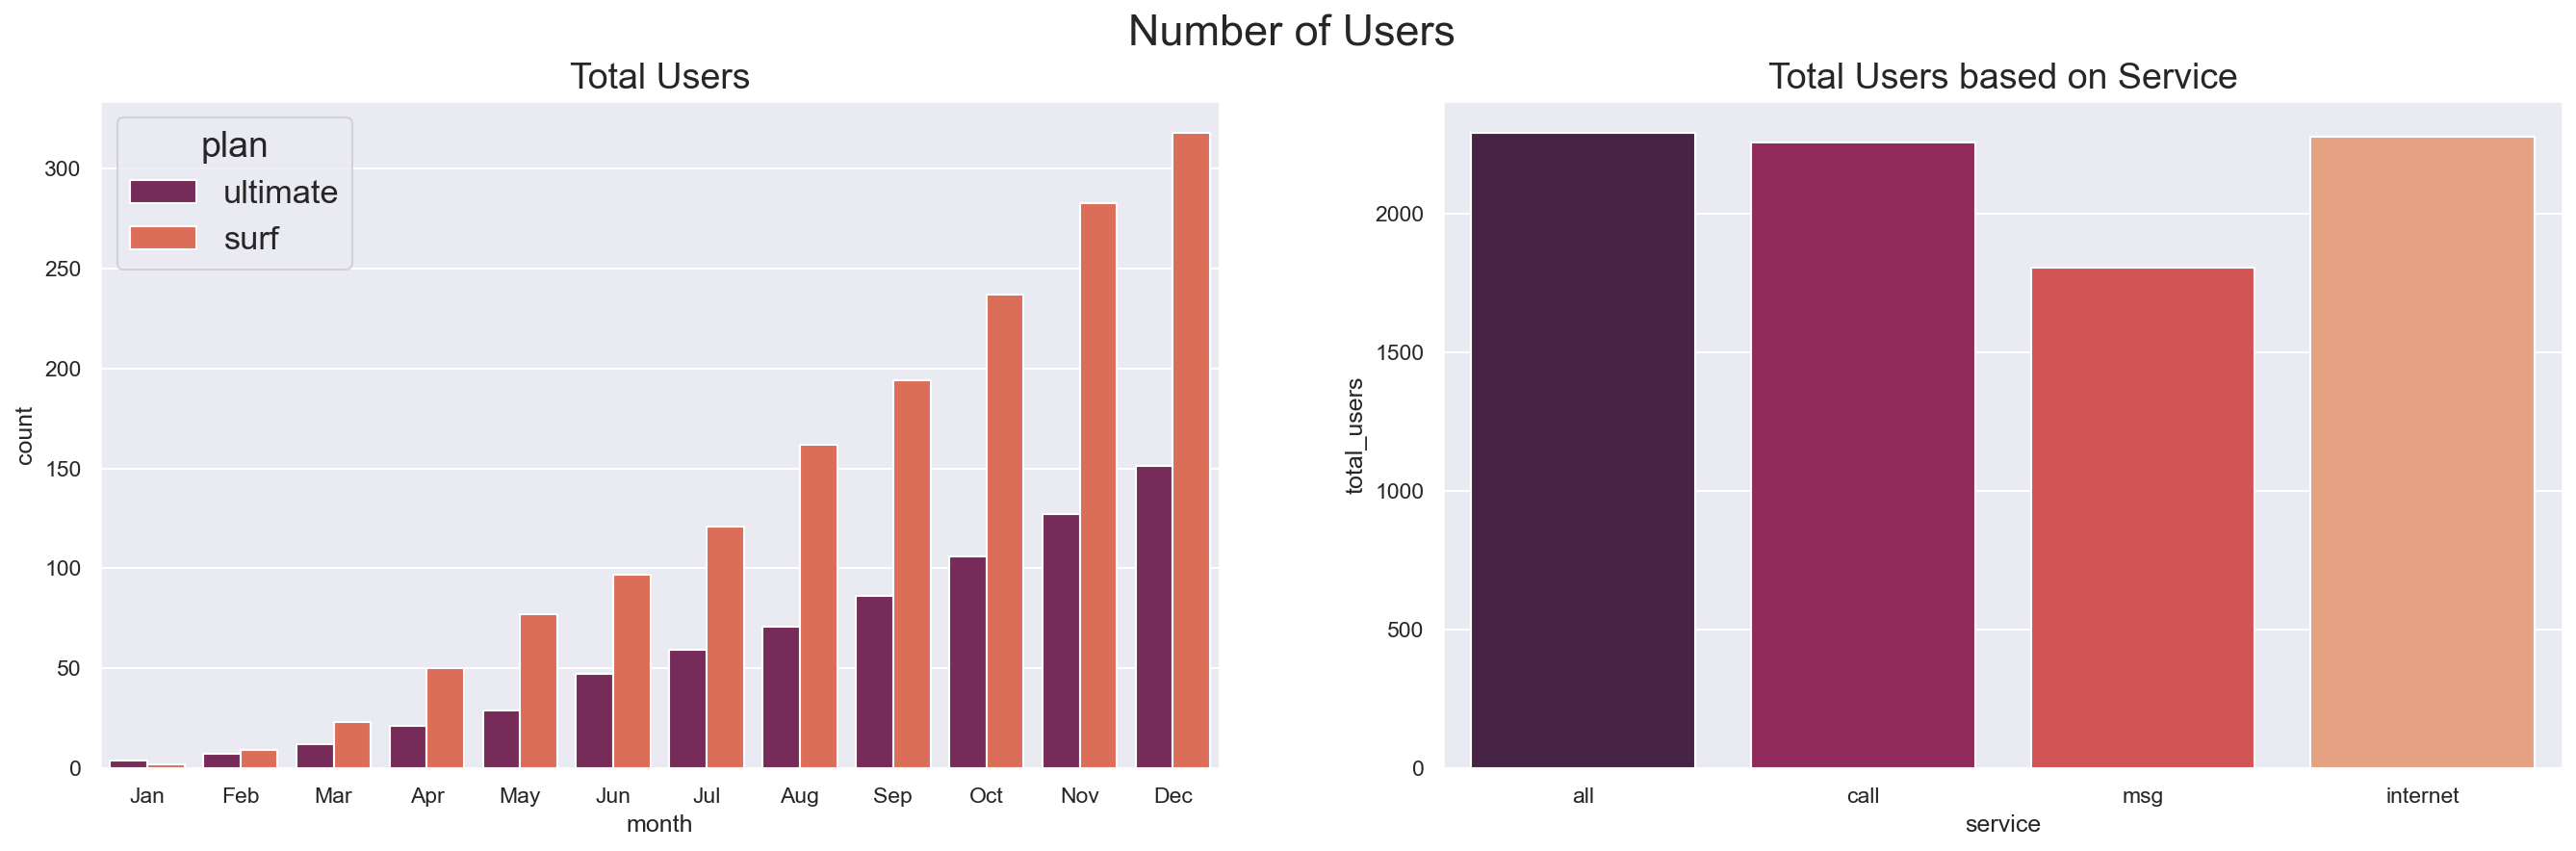

In [42]:
# learn service that mostly are used by users

figure, axes = plt.subplots(1,2, figsize=(22,6), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Number of Users')

(sns.countplot(ax=axes[0], data=monthly_usage, x='month', hue='plan', palette='rocket',
             order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    .set(title='Total Users'))

(sns.barplot(ax=axes[1], data=total_users, x='service', y='total_users', palette='rocket')
     .set(title='Total Users based on Service'))

plt.show()

**Findings:**
- Most of the customers use plan Surf rather than Ultimate
- During 2018, the number of customers from both plans rose gradually each month up to the end of December
- The increase of Surf users seems to be higher than Ultimate users
- Almost all users use to call and internet service
- The lowest feature usage is message service.

### Calls

In [43]:
# describe call_users

call_users.describe()

total_calls  call_duration    usd_month  minutes_plan  usd_per_minute  \
count  2258.000000    2258.000000  2258.000000   2258.000000     2258.000000   
mean     60.998671     435.937555    35.788308   1289.415412        0.023685   
std      31.770869     231.972343    23.246162   1162.308107        0.009298   
min       1.000000       0.000000    20.000000    500.000000        0.010000   
25%      39.000000     275.000000    20.000000    500.000000        0.010000   
50%      60.000000     429.000000    20.000000    500.000000        0.030000   
75%      80.000000     574.750000    70.000000   3000.000000        0.030000   
max     205.000000    1510.000000    70.000000   3000.000000        0.030000   

       call_charge  
count  2258.000000  
mean      1.284433  
std       3.255103  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.030000  
max      30.300000

In [44]:
# categorize call users based on the plan, individual user, and month
# for distribution analysis (histogram)

# group call users
# replace month with a sortable value
# sort rows by month
call_user_group = (call_users.pivot_table(index=['plan', 'user_id', 'month'],
                       values= ['call_charge', 'total_calls', 'call_duration']).reset_index()
                       .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
                       .set_index('month')
                       .sort_index()
                       .reset_index()
)

# replace month index from number 'int' to name 'str'
call_user_group['month'] = call_user_group['month'].apply(lambda x: calendar.month_abbr[x])

# check the result
call_user_group.head()

month      plan user_id  call_charge  call_duration  total_calls
0   Jan  ultimate    1196          0.0          287.0         42.0
1   Jan  ultimate    1077          0.0          290.0         42.0
2   Jan      surf    1362          0.0          292.0         42.0
3   Jan      surf    1042          0.0          114.0         18.0
4   Jan  ultimate    1214          0.0           16.0          5.0

In [45]:
# create function to remove outlier drom dataset

def remove_outliers (data, variable):
  
  '''
  This function will calculate the IQR value, lower bound, and upper bound of the data series/ column in the dataframe.
  Those values will be used to remove rows containing potential outliers values and return a new data frame.
  Data: Dataframe or series
  Variable: an interesting column that will be analyzed.  
  '''
  
  Q1 = data[variable].quantile(0.25)
  Q3 = data[variable].quantile(0.75)
  IQR = Q3-Q1
  lower_bound = Q1-1.5*IQR 
  upper_bound = Q3+1.5*IQR

  new_data = (data.loc[(data[variable]>lower_bound) & 
                   (data[variable]>0) &
                   (data[variable]<upper_bound)])
  return new_data

In [46]:
# generate clean data
# apply function to remove outliers

clean_call_duration = remove_outliers(call_user_group, 'call_duration')

clean_total_calls = remove_outliers(call_user_group, 'total_calls')

clean_call_charge = remove_outliers(call_user_group, 'call_charge')

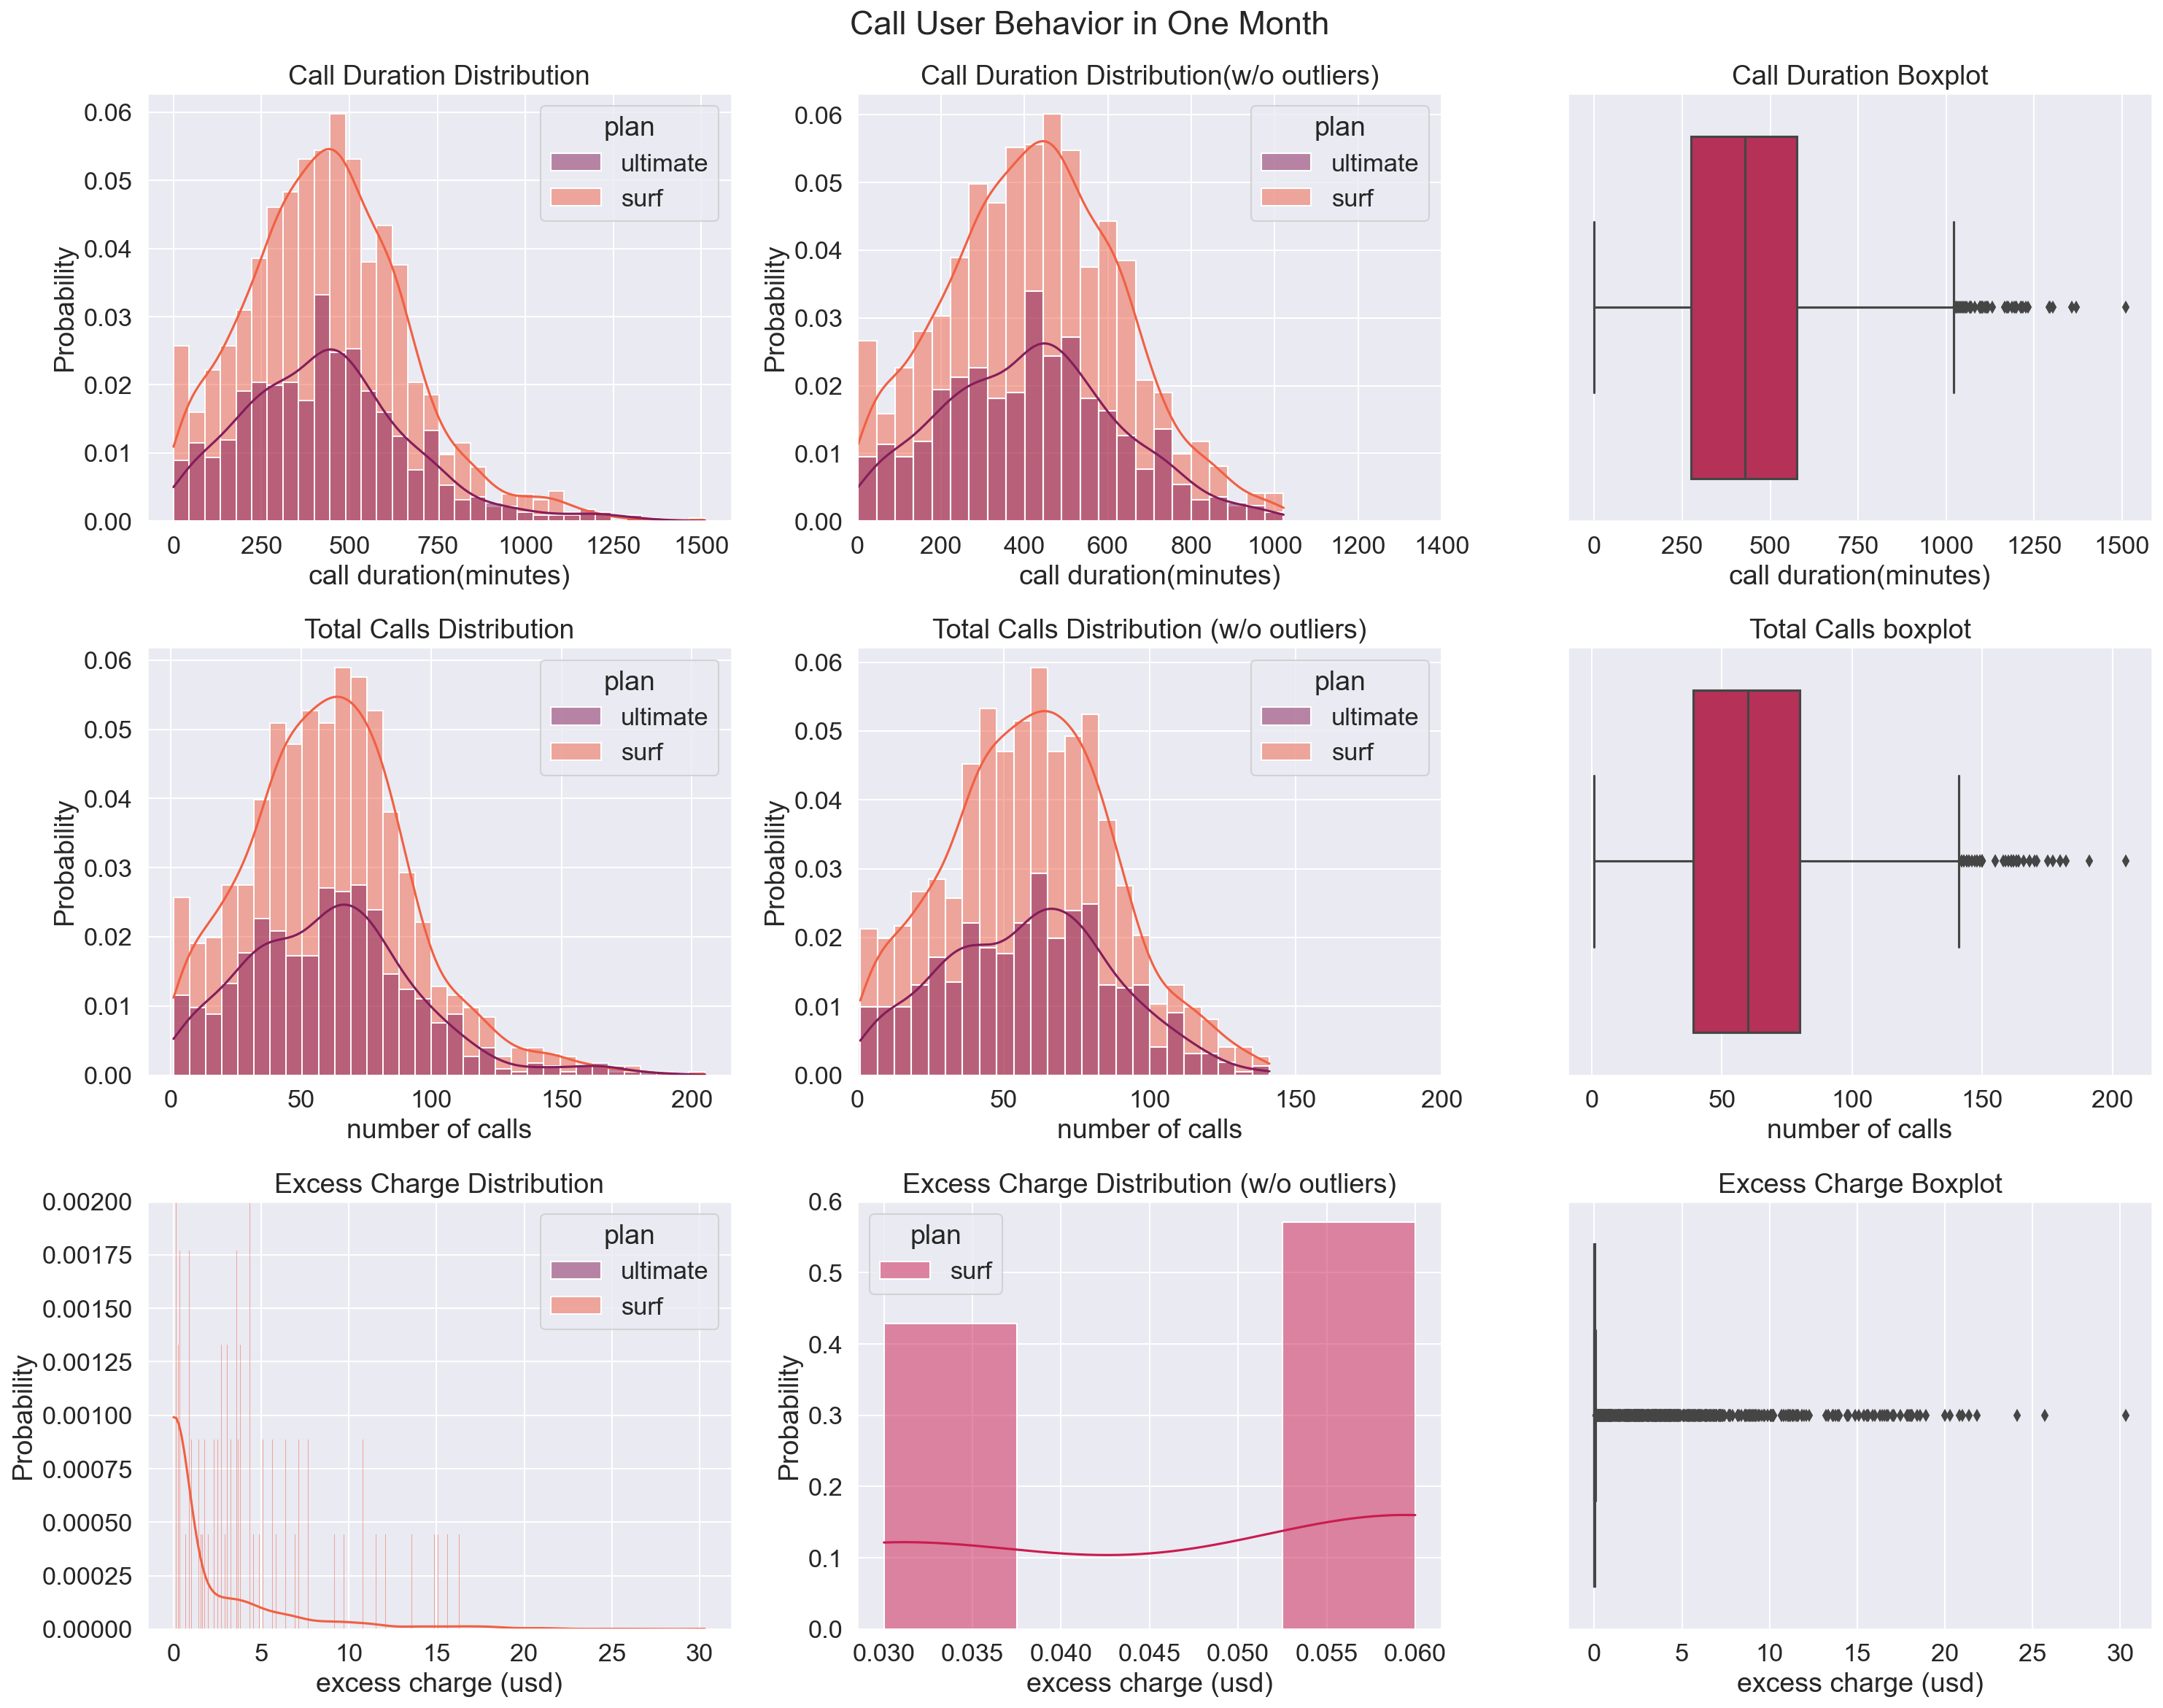

In [47]:
# create histogram
# over all distribution in call user

figure, axes = plt.subplots(3,3, figsize=(20,16), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Call User Behavior in One Month')

#--------------------------------------------------------------------------------------------------------------------------------------------------
# call duration distribution
(sns.histplot(ax=axes[0,0], data=call_user_group, x='call_duration', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Call Duration Distribution', xlabel='call duration(minutes)')
)
#------------------------------------------------
(sns.histplot(ax=axes[0,1], data=clean_call_duration, x='call_duration', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Call Duration Distribution(w/o outliers)', xlabel='call duration(minutes)', xlim=(0,1400))
)
#------------------------------------------------
(sns.boxplot(ax=axes[0,2], data=call_user_group, x='call_duration', 
              hue='plan', palette='rocket')
    .set(title='Call Duration Boxplot', xlabel='call duration(minutes)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# total calls distribution
(sns.histplot(ax=axes[1,0], data=call_user_group, x='total_calls', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Total Calls Distribution', xlabel='number of calls')
)
#------------------------------------------------
(sns.histplot(ax=axes[1,1], data=clean_total_calls, x='total_calls', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Total Calls Distribution (w/o outliers)', xlabel='number of calls', xlim=(0,200))
)
#------------------------------------------------
(sns.boxplot(ax=axes[1,2], data=call_user_group, x='total_calls', 
              hue='plan', palette='rocket')
    .set(title='Total Calls boxplot', xlabel='number of calls')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# excess charge distribution
(sns.histplot(ax=axes[2,0], data=call_user_group, x='call_charge', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Excess Charge Distribution', xlabel='excess charge (usd)', ylim=(0, 0.002))
)
#------------------------------------------------
(sns.histplot(ax=axes[2,1], data=clean_call_charge, x='call_charge', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Excess Charge Distribution (w/o outliers)', xlabel='excess charge (usd)')
)
#------------------------------------------------
(sns.boxplot(ax=axes[2,2], data=call_user_group, x='call_charge', 
              hue='plan', palette='rocket')
    .set(title='Excess Charge Boxplot', xlabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------


plt.tight_layout()
plt.show()

**Findings:**
- Both outliers in call duration and total calls are seemed have minor influence to the distribution of data
- Both plans have similar distribution patterns in call duration and total calls in one month
- Both plans tend to have normal distribution in call duration and total calls
- The Ultimate users rarely get the excess charge
- The Surf users have tend to get excess charge


**Insight:**
- Users in both plans tend to have similar behaviour on call service usage (call duration and total calls in one month)
- The limit call duration in Ultimate (3,000 minutes) can cover the users needs
- Since the majority of call needs from all users tend to be similar, the Surf users are most likely cross the limit usages (500 minutes) and pay for the extra charge

In [48]:
# categorize call users based plan and month
# for average and median analysis (barplot)

call_month_group = (call_user_group
 .groupby(['plan','month'], as_index=False)
 .agg(median_call_duration=('call_duration', 'median'),
      mean_call_duration=('call_duration', 'mean'),
      median_call_charge=('call_charge', 'median'),
      mean_call_charge=('call_charge', 'mean'),
      median_total_calls=('total_calls', 'median'),
      mean_total_calls=('total_calls', 'mean'))
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
call_month_group['month'] = call_month_group['month'].apply(lambda x: calendar.month_abbr[x])


call_month_group.head()

month      plan  median_call_duration  mean_call_duration  \
0   Jan      surf                 203.0          203.000000   
1   Jan  ultimate                 234.0          193.500000   
2   Feb      surf                 254.0          297.000000   
3   Feb  ultimate                 473.5          470.333333   
4   Mar      surf                 334.0          330.000000   

   median_call_charge  mean_call_charge  median_total_calls  mean_total_calls  
0                 0.0          0.000000                30.0         30.000000  
1                 0.0          0.000000                32.5         28.000000  
2                 0.0          1.036667                37.0         40.666667  
3                 0.0          0.000000                70.5         68.000000  
4                 0.0          0.706957                49.0         46.434783

In [49]:
# categorize call users based plan and month
# for average and median analysis (barplot)
# seperate Surf and Ultimate plan

#SURF
call_month_group_surf = (call_month_group.query("plan=='surf'")
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
call_month_group_surf['month'] = call_month_group_surf['month'].apply(lambda x: calendar.month_abbr[x])


#ULTIMATE
call_month_group_ultimate = (call_month_group.query("plan=='ultimate'")
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
call_month_group_ultimate['month'] = call_month_group_ultimate['month'].apply(lambda x: calendar.month_abbr[x])


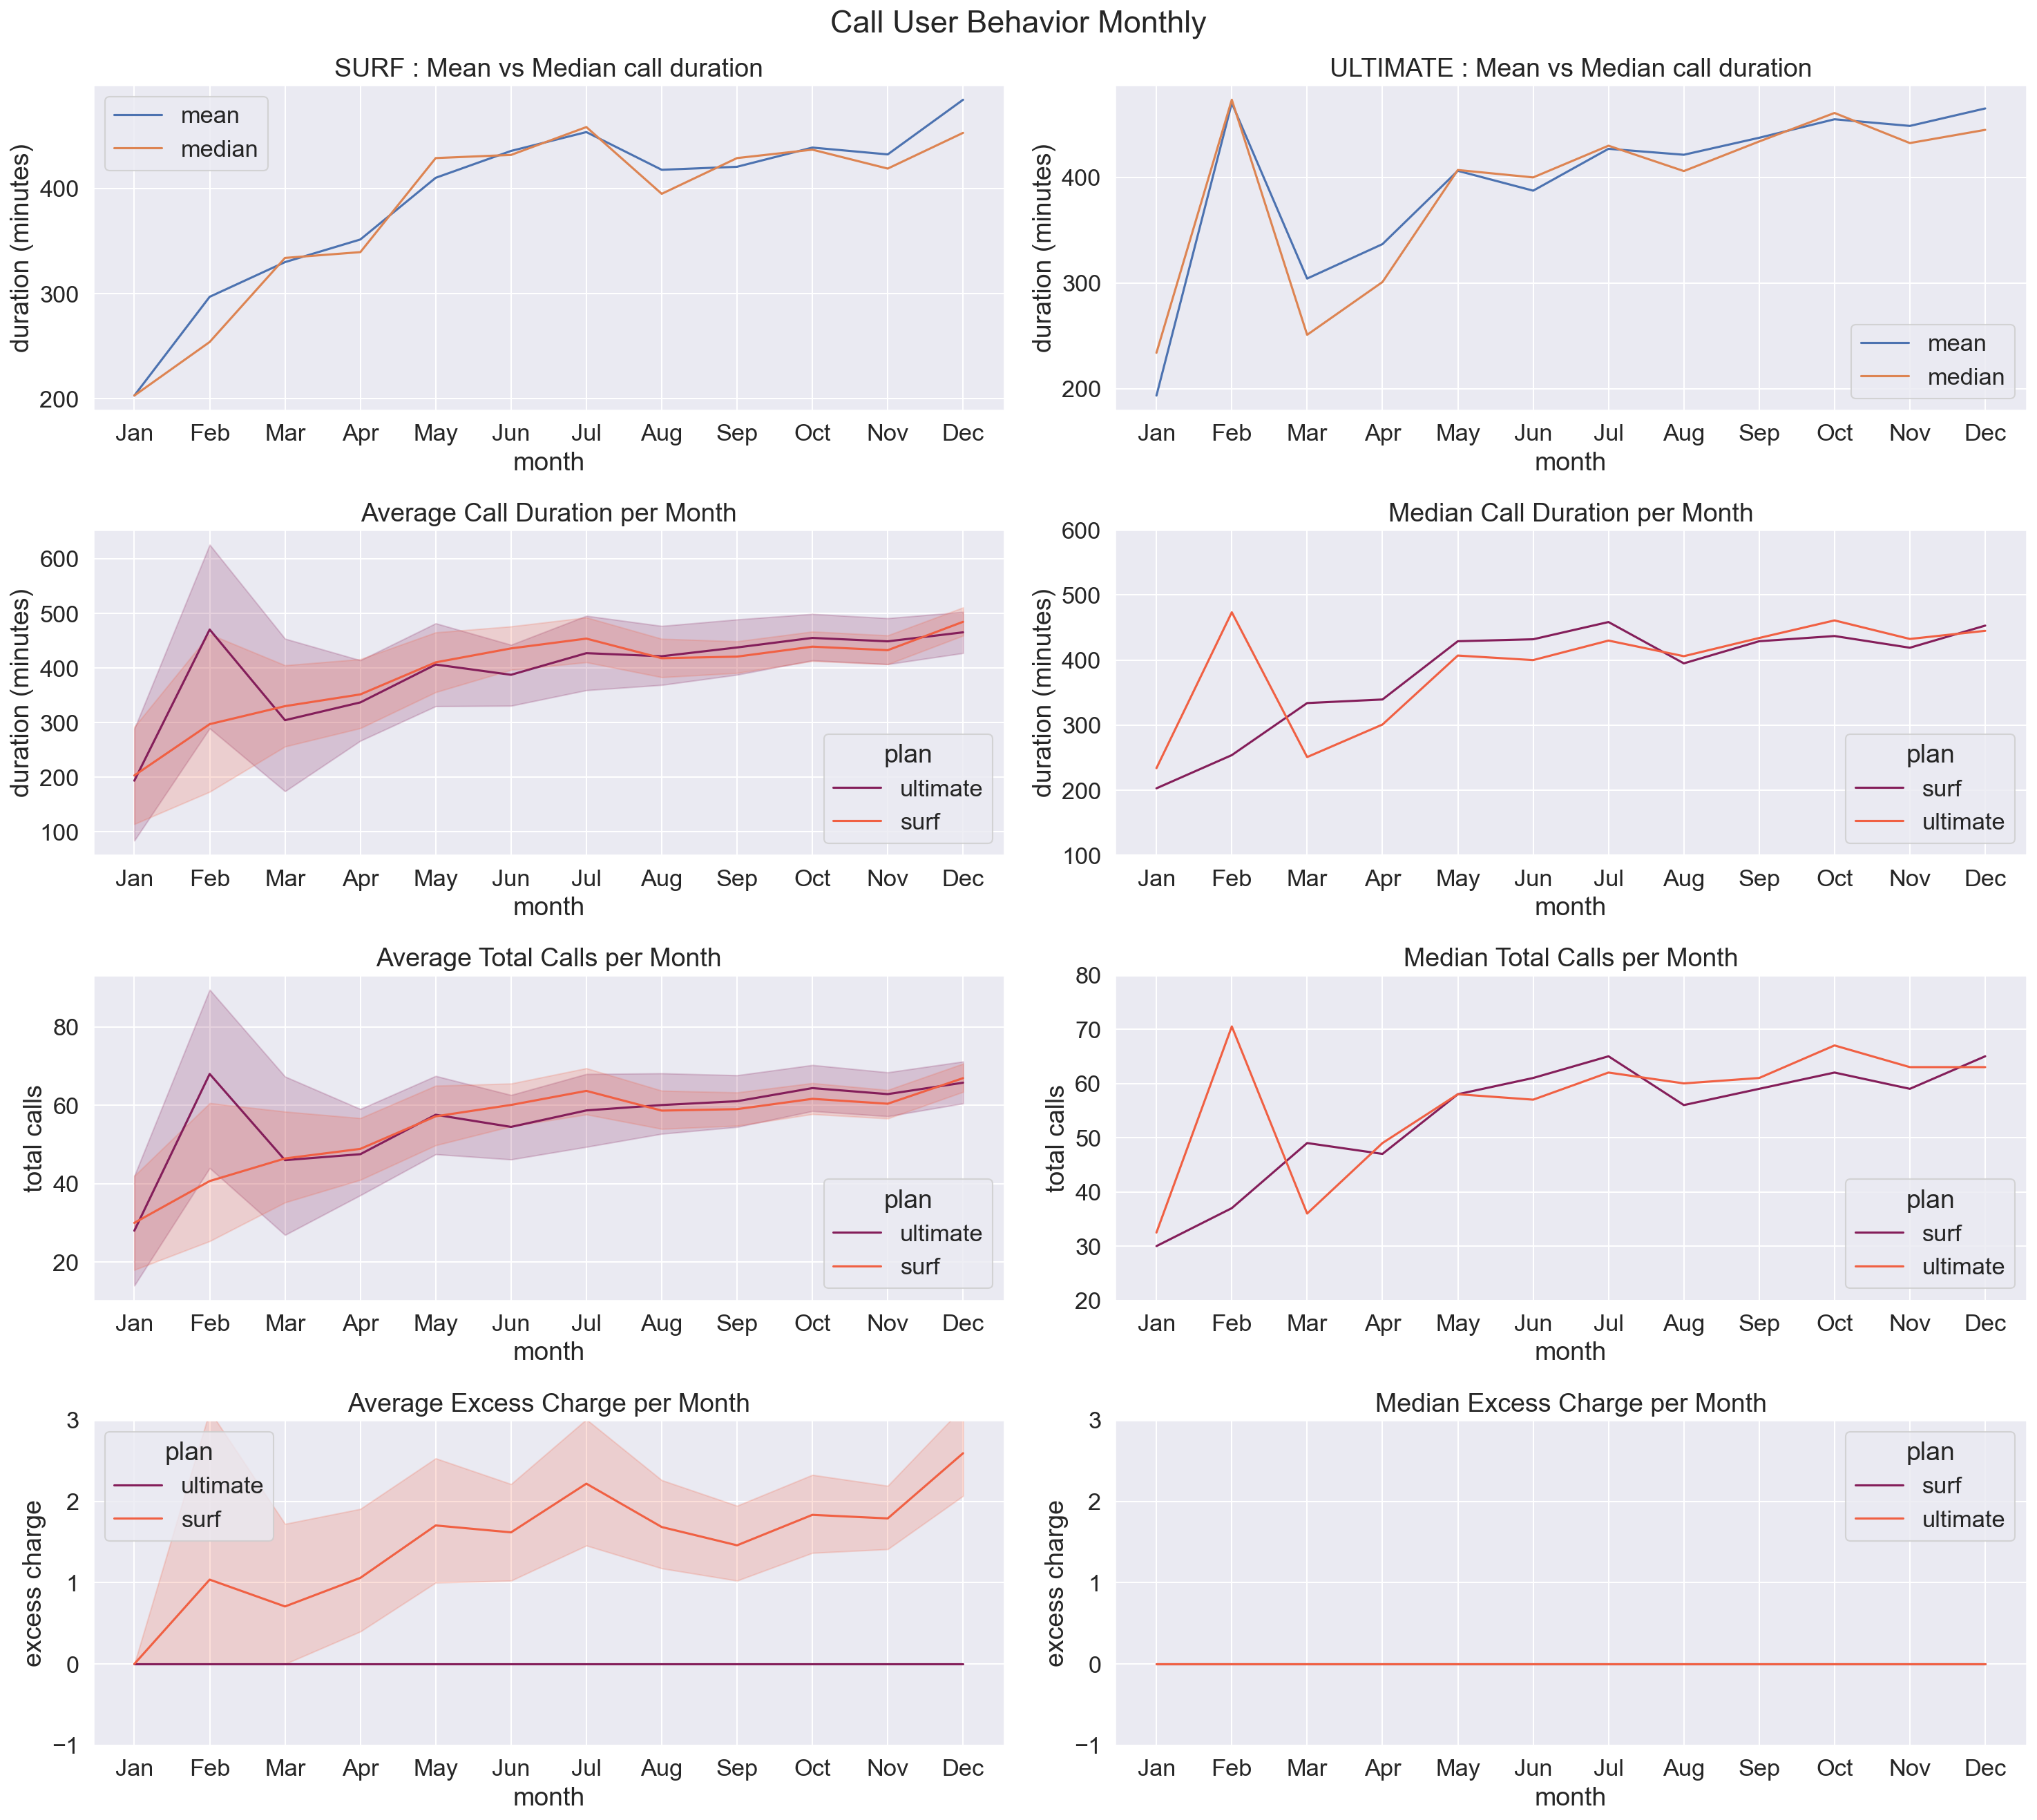

In [50]:
# create chart
# over all mean and median
figure, axes = plt.subplots(4,2, figsize=(20,18), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Call User Behavior Monthly')


#--------------------------------------------------------------------------------------------------------------------------------------------------
# SURF: Mean and Median Gap in Call Duration
(sns.lineplot(ax=axes[0,0], data=call_month_group_surf, x='month',
             y='mean_call_duration', palette='flare',
              err_style='bars', label='mean')
    .set(title='SURF : Mean vs Median call duration', ylabel='duration (minutes)')
)

(sns.lineplot(ax=axes[0,0], data=call_month_group_surf, x='month',
             y='median_call_duration', palette='Blues',
              err_style='bars', label='median')
    .set(title='SURF : Mean vs Median call duration', ylabel='duration (minutes)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# ULTIMATE: Mean and Median Gap in Call Duration
(sns.lineplot(ax=axes[0,1], data=call_month_group_ultimate, x='month',
             y='mean_call_duration', palette='YlOrBr', 
              err_style='bars', label='mean')
    .set(title='ULTIMATE : Mean vs Median call duration', ylabel='duration (minutes)')
)

(sns.lineplot(ax=axes[0,1], data=call_month_group_ultimate, x='month',
             y='median_call_duration', palette='Blues',
              err_style='bars', label='median')
    .set(title='ULTIMATE : Mean vs Median call duration', ylabel='duration (minutes)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Call Duration per Month
(sns.lineplot(ax=axes[1,0], data=call_user_group, x='month',
             y='call_duration', hue='plan', palette='rocket')
    .set(title='Average Call Duration per Month', ylabel='duration (minutes)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Median Call Duration per Month
(sns.lineplot(ax=axes[1,1], data=call_month_group, x='month',
             y='median_call_duration', hue='plan', palette='rocket')
    .set(title='Median Call Duration per Month', ylabel='duration (minutes)', ylim=(100,600))
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Total Calls per Month
(sns.lineplot(ax=axes[2,0], data=call_user_group, x='month',
             y='total_calls', hue='plan', palette='rocket')
     .set(title='Average Total Calls per Month', ylabel='total calls')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Median Total Calls per Month
(sns.lineplot(ax=axes[2,1], data=call_month_group, x='month',
             y='median_total_calls', hue='plan', palette='rocket')
    .set(title='Median Total Calls per Month', ylim=(20,80), ylabel='total calls')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Excess Charge per Month
(sns.lineplot(ax=axes[3,0], data=call_user_group, x='month',
             y='call_charge', hue='plan', palette='rocket')
    .set(title='Average Excess Charge per Month', ylim=(-1,3), ylabel='excess charge')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Median Excess Charge per Month
(sns.lineplot(ax=axes[3,1], data=call_month_group, x='month',
             y='median_call_charge', hue='plan', palette='rocket')
    .set(title='Median Excess Charge per Month', ylim=(-1,3), ylabel='excess charge')
)
#--------------------------------------------------------------------------------------------------------------------------------------------------


plt.tight_layout()
plt.show()

**Findings:**
- The mean and median value in call duration from both plans tend to be similar. It's because of the normal distribution
- The average call durations and total calls, from both plans, tend to increase gradually during one year
- The rise pattern from both users plans tend to be similar, unless in February
- There is an increase in call usage from Ultimate Users in February
- The average excess charge in Surf user rise gradually in one year
- The majority users from both plans are most likely don't get excess charge


**Insight:**
- Users in both plans tend to have similar behaviour on call service usage (call duration and total calls)
- The increase in call service usage during one year in line with the grow of user numbers (previous chart)
 

**Recommendation**
- It would be better to conduct further investigation to acknowledge the reason behind the increase of call service usage
- We should analysis whether the pattern will keep increasing in line with the grow of customers/promotion or It's just an interable pattern in one year
- We should find the reason behind anomaly call service usage from Ultimate Users in February. Whether It is caused by particular occasion (like valentine days, incident, or any special promotion). Perhaps, Its insight might give an inspiration for further strategy to increase the call service demand 


<div class="alert alert-block alert-warning">
<b>Reviewer's comment v1</b> <a class="tocSkip"></a>

I have problem-related with the graphic color.
Every time I change the dataset and generate the lineplot, the color legend between Surf and Ultimate is often different. I want to generate 'orange-red' to represent the Surf plan and 'purple' to represent Ultimate plan (from pallete : 'rocket')

Would you like to hepl me?
Thank you

</div>

### Messages

In [51]:
# describe msg_users

msg_users.describe()

index    total_msg    usd_month     msg_plan  usd_per_msg  \
count  1806.000000  1806.000000  1806.000000  1806.000000  1806.000000   
mean   1165.256921    42.110188    36.168328   357.198228     0.023533   
std     656.923717    33.122931    23.394542   444.496306     0.009358   
min       0.000000     1.000000    20.000000    50.000000     0.010000   
25%     601.250000    17.000000    20.000000    50.000000     0.010000   
50%    1174.000000    34.000000    20.000000    50.000000     0.030000   
75%    1732.750000    59.000000    70.000000  1000.000000     0.030000   
max    2292.000000   266.000000    70.000000  1000.000000     0.030000   

        msg_charge  
count  1806.000000  
mean      0.183239  
std       0.549669  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       6.480000

In [52]:
# categorize msg_users based on plan, individual user, and month
# for distribution analysis (histogram)

# group msg_users
# replace month into sortable value
# sort rows by month
msg_user_group = (msg_users.pivot_table(index=['plan', 'user_id', 'month'],
                       values= ['msg_charge', 'total_msg']).reset_index()
                       .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
                       .set_index('month')
                       .sort_index()
                       .reset_index()
)

# replace month index from number 'int' to name 'str'
msg_user_group['month'] = msg_user_group['month'].apply(lambda x: calendar.month_abbr[x])

# check the result
msg_user_group.head()

month      plan user_id  msg_charge  total_msg
0   Jan      surf    1362         0.0       21.0
1   Jan  ultimate    1077         0.0       37.0
2   Jan  ultimate    1214         0.0        2.0
3   Jan  ultimate    1196         0.0       23.0
4   Feb  ultimate    1028         0.0       12.0

In [53]:
# generate clean data
# apply function to remove outliers

clean_total_msg = remove_outliers(msg_user_group, 'total_msg')

clean_msg_charge = remove_outliers(msg_user_group, 'msg_charge')

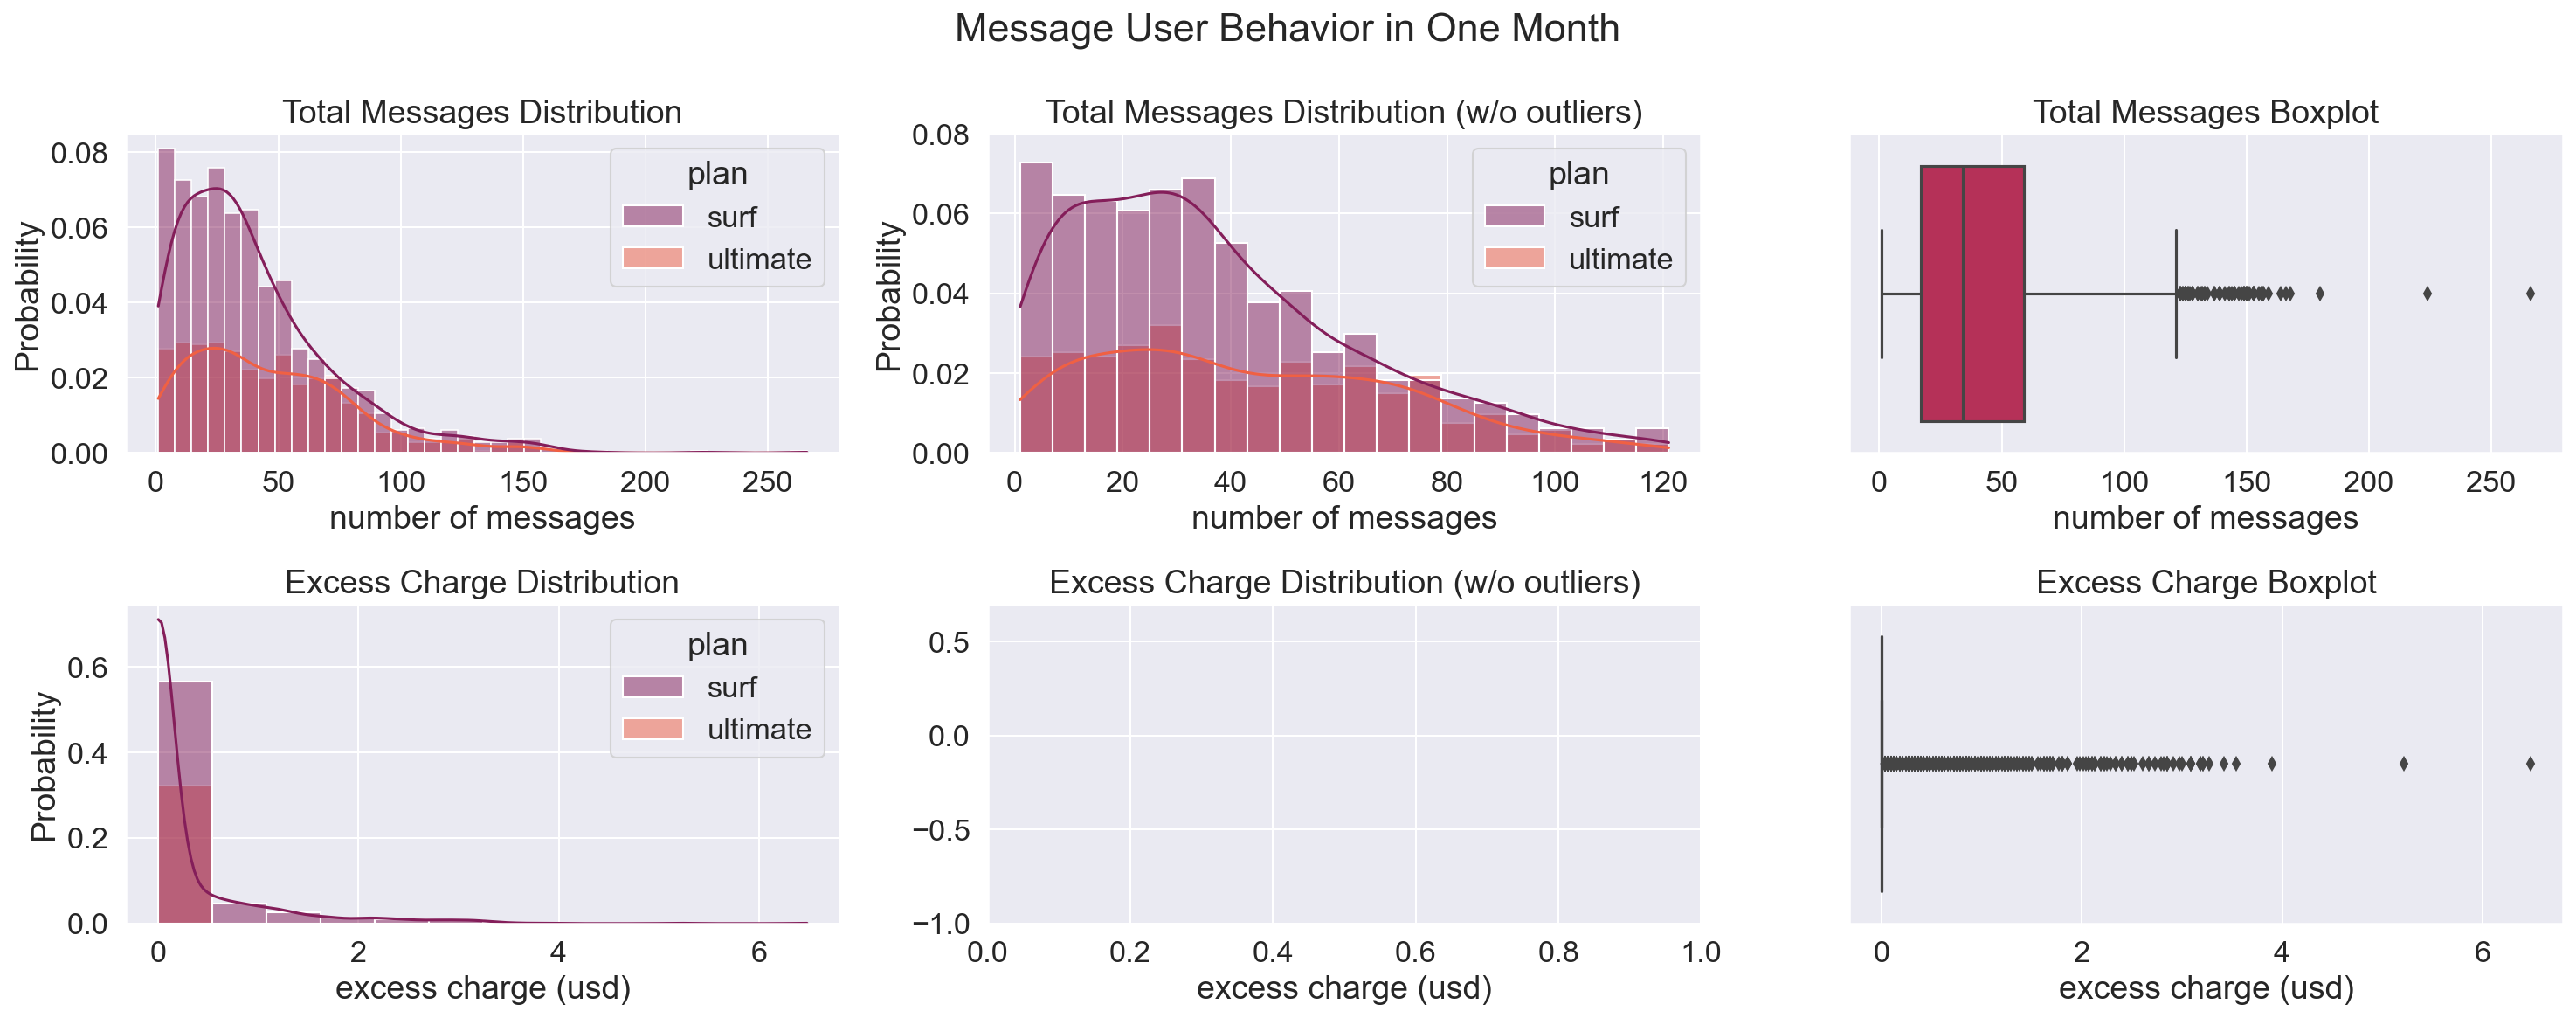

In [54]:
# create histogram
# over all distribution in msg_users

figure, axes = plt.subplots(2,3, figsize=(20,8), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Message User Behavior in One Month')

#--------------------------------------------------------------------------------------------------------------------------------------------------
# total message distribution
(sns.histplot(ax=axes[0,0], data=msg_user_group, x='total_msg', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Total Messages Distribution', xlabel='number of messages')
)

#------------------------------------------------
(sns.histplot(ax=axes[0,1], data=clean_total_msg, x='total_msg', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Total Messages Distribution (w/o outliers)', xlabel='number of messages', ylim=(0,0.08))
)

#------------------------------------------------
(sns.boxplot(ax=axes[0,2], data=msg_user_group, x='total_msg', 
              hue='plan', palette='rocket')
    .set(title='Total Messages Boxplot', xlabel='number of messages')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# excess charge distribution
(sns.histplot(ax=axes[1,0], data=msg_user_group, x='msg_charge', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Excess Charge Distribution', xlabel='excess charge (usd)')
)

#------------------------------------------------
(sns.histplot(ax=axes[1,1], data=clean_msg_charge, x='msg_charge', hue='plan', kde=True,
              palette='rocket', stat='probability')
    .set(title='Excess Charge Distribution (w/o outliers)', xlabel='excess charge (usd)', ylim=(-1,0.7))
)

#------------------------------------------------
(sns.boxplot(ax=axes[1,2], data=msg_user_group, x='msg_charge', 
              hue='plan', palette='rocket')
    .set(title='Excess Charge Boxplot', xlabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------

 
plt.tight_layout()
plt.show()

**Findings:**
- The distribution of total messages that users sent in one month from both plans tend to be similar
- The total message distributions are skewed positively
- The outliers from both plans seem to have a minor influence on data distribution
- Users from both plans tend not to get extra charge in message service
- Only minority users (especially Surf Users) are charged for the excess limit
- Almost 75% of users from both plans send text below 59 messages in one month


**Insight:**
- Users in both plans tend to have similar behavior on message service usage
- The majority of users (75%) don't get charged by excessing the message limits.
- It seems that the total messages limit (50 msg/month) from the Surf plan is adequate for the majority of users
- The message limit in Ultimate (1000 msg/month) seems to be over-supplied. During 2018, the highest number of messages that can be sent from one user is 266 messages

In [55]:
# categorize msg_users based plan and month
# for average and median analysis (barplot)

msg_month_group = (msg_user_group
 .groupby(['plan','month'], as_index=False)
 .agg(median_msg_charge=('msg_charge', 'median'),
      mean_msg_charge=('msg_charge', 'mean'),
      median_total_msg=('total_msg', 'median'),
      mean_total_msg=('total_msg', 'mean'))
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
msg_month_group['month'] = msg_month_group['month'].apply(lambda x: calendar.month_abbr[x])


msg_month_group.head()

month      plan  median_msg_charge  mean_msg_charge  median_total_msg  \
0   Jan      surf                0.0         0.000000              21.0   
1   Jan  ultimate                0.0         0.000000              23.0   
2   Feb      surf                0.0         0.048000              11.0   
3   Feb  ultimate                0.0         0.000000              19.0   
4   Mar      surf                0.0         0.024375              18.5   

   mean_total_msg  
0       21.000000  
1       20.666667  
2       21.600000  
3       25.166667  
4       21.937500

In [56]:
# categorize msg_users based plan and month
# for average and median analysis (barplot)
# seperate Surf and Ultimate plan

msg_month_group_surf = (msg_month_group.query("plan=='surf'")
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
msg_month_group_surf['month'] = msg_month_group_surf['month'].apply(lambda x: calendar.month_abbr[x])


msg_month_group_ultimate = (msg_month_group.query("plan=='ultimate'")
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
msg_month_group_ultimate['month'] = msg_month_group_ultimate['month'].apply(lambda x: calendar.month_abbr[x])


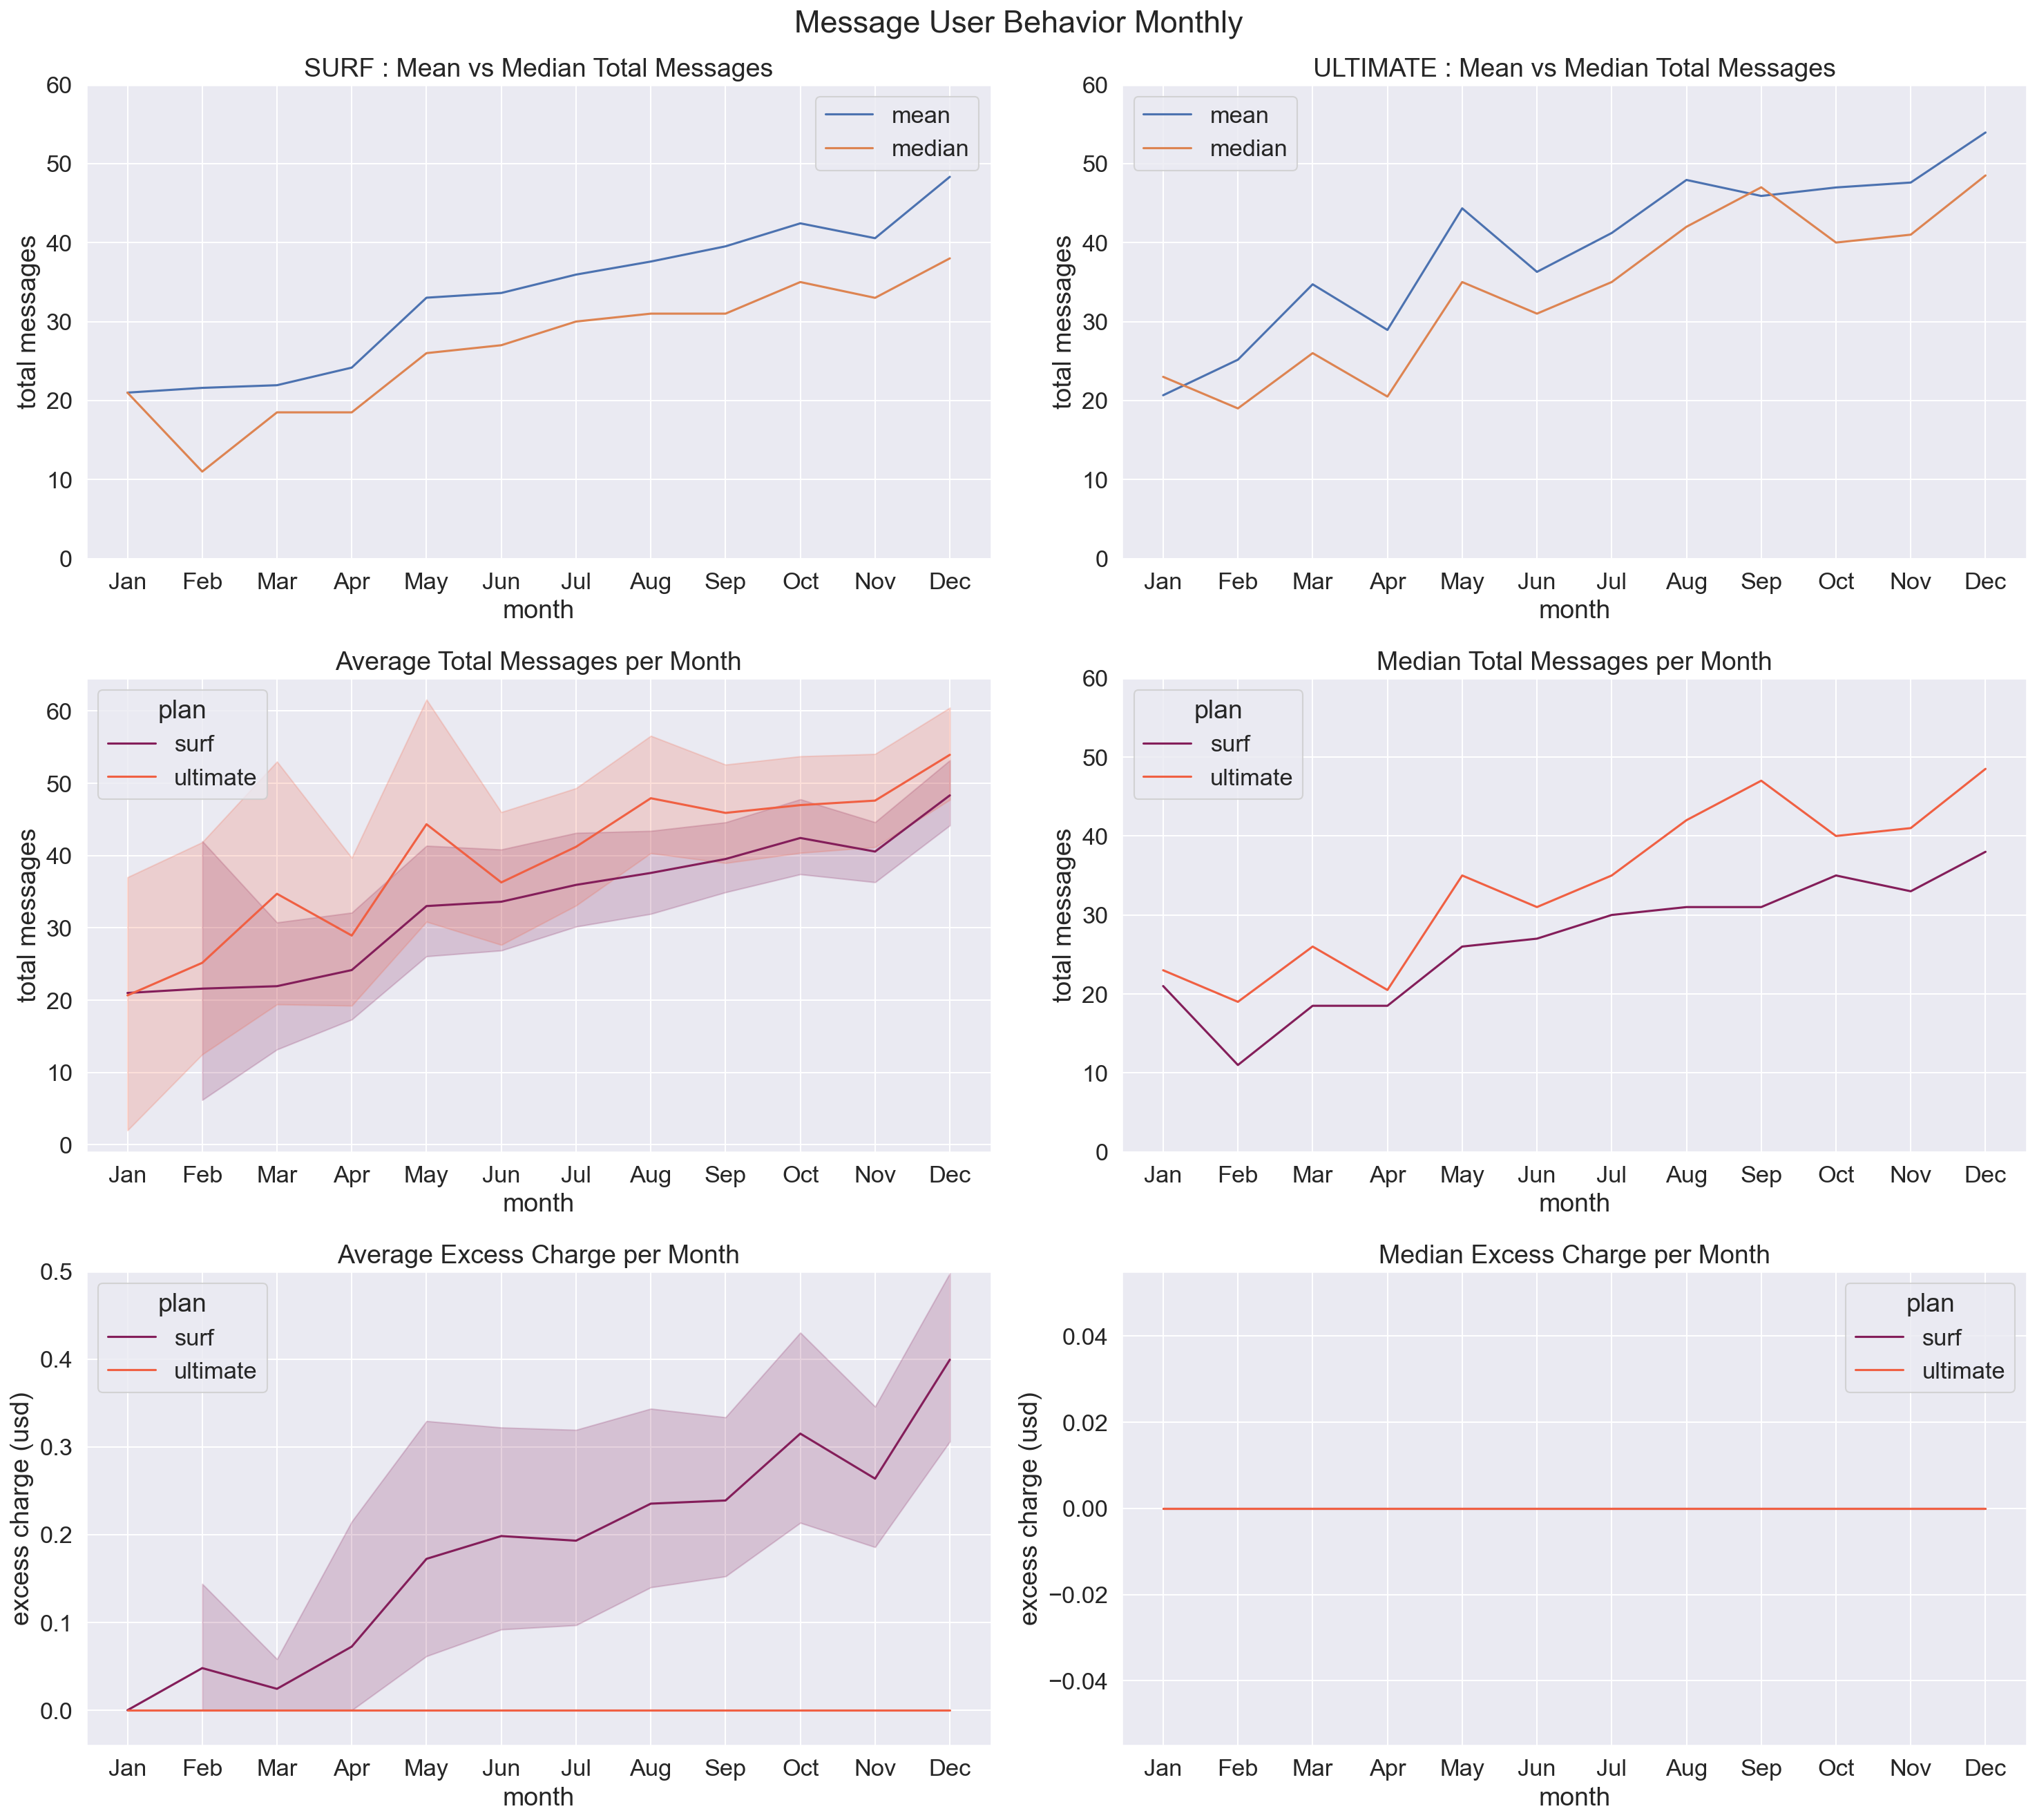

In [57]:
# create chart
# over all mean and median
figure, axes = plt.subplots(3,2, figsize=(20,18), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Message User Behavior Monthly')


#--------------------------------------------------------------------------------------------------------------------------------------------------
# SURF: Mean and Median Gap in Total Messages
(sns.lineplot(ax=axes[0,0], data=msg_month_group_surf, x='month',
             y='mean_total_msg', palette='YlOrBr',
              err_style='bars', label='mean')
    .set(title='SURF : Mean vs Median Total Messages', ylim=(0,60), ylabel='total messages')
)

(sns.lineplot(ax=axes[0,0], data=msg_month_group_surf, x='month',
             y='median_total_msg', palette='Blues',
              err_style='bars', label='median')
    .set(title='SURF : Mean vs Median Total Messages', ylim=(0,60), ylabel='total messages')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# ULTIMATE: Mean and Median Gap in Total Messages
(sns.lineplot(ax=axes[0,1], data=msg_month_group_ultimate, x='month',
             y='mean_total_msg', palette='YlOrBr', 
              err_style='bars', label='mean')
    .set(title='ULTIMATE : Mean vs Median Total Messages', ylim=(0,60), ylabel='total messages')
)

(sns.lineplot(ax=axes[0,1], data=msg_month_group_ultimate, x='month',
             y='median_total_msg', palette='Blues',
              err_style='bars', label='median')
    .set(title='ULTIMATE : Mean vs Median Total Messages', ylim=(0,60), ylabel='total messages')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Total Messages per Month
(sns.lineplot(ax=axes[1,0], data=msg_user_group, x='month',
             y='total_msg', hue='plan', palette='rocket')
    .set(title='Average Total Messages per Month', ylabel='total messages')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Median Total Messages per Month
(sns.lineplot(ax=axes[1,1], data=msg_month_group, x='month',
             y='median_total_msg', hue='plan', palette='rocket')
    .set(title='Median Total Messages per Month', ylim=(0,60), ylabel='total messages')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Excess Charge per Month
(sns.lineplot(ax=axes[2,0], data=msg_user_group, x='month',
             y='msg_charge', hue='plan', palette='rocket')
     .set(title='Average Excess Charge per Month', ylim=(-0.04, 0.5), ylabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Median Excess Charge per Month
(sns.lineplot(ax=axes[2,1], data=msg_month_group, x='month',
             y='median_msg_charge', hue='plan', palette='rocket')
    .set(title='Median Excess Charge per Month', ylabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------


plt.tight_layout()
plt.show()

**Findings:**
- Since the distribution of total messages from both plans is skewed positively, the mean is higher than the median
- Ultimate users tend to send more messages than Surf Users
- The total messages sent from both plans tend  to increase gradually during one year
- None of the Ultimate users excess the total message limit
- The average excess charge from Surf Users increase gradually during one year
- Although there's an increase in excess charge in Surf users, most of the Surf users don't get excess charge

**Insight**
- There's an increase in message service usage during on year
- The average user sends message no more than 50 msg/month, this makes the Surf limit plan adequate for the majority of users
- The messages limit of Ultimate Plan (1000 msg/month) seems to be over the limit
- Most of the users don't get extra charges since the message limit from both plans can cover their needs

**Recomendation**
- It would be better to conduct further investigation to acknowledge the reason behind the increase in message service usage during one year
- We should analyze whether the pattern will keep increasing in line with the growth of customers/promotions or It's just an iterable pattern in one year
- For maximizing the service and profit, We can re-evaluate the message limit from each plan

### Internet

In [58]:
# describe internet_users

internet_users.describe()

index      total_mb     total_gb    usd_month       mb_plan  \
count  2277.000000   2277.000000  2277.000000  2277.000000   2277.000000   
mean   1147.723759  16882.197501    16.989021    35.788318  20210.171278   
std     662.581595   7869.784848     7.693683    23.246123   7141.208996   
min       0.000000     92.310000     1.000000    20.000000  15360.000000   
25%     574.000000  12347.720000    13.000000    20.000000  15360.000000   
50%    1149.000000  16873.740000    17.000000    20.000000  15360.000000   
75%    1722.000000  21041.520000    21.000000    70.000000  30720.000000   
max    2292.000000  70931.590000    70.000000    70.000000  30720.000000   

           gb_plan   usd_per_gb  internet_charge  
count  2277.000000  2277.000000      2277.000000  
mean     19.736495     9.052701        27.433465  
std       6.973837     1.394767        48.688228  
min      15.000000     7.000000         0.000000  
25%      15.000000     7.000000         0.000000  
50%      15.000000    10.000000         0.000000  
75%      30.000000    10.000000        40.000000  
max      30.000000    10.000000       550.000000

In [60]:
# categorize internet_users based on plan, individual user, and month
# for distribution analysis (histogram)

# group internet_users
# replace month into sortable value
# sort rows by month
internet_user_group = (internet_users.pivot_table(index=['plan', 'user_id', 'month'],
                       values= ['internet_charge', 'total_gb']).reset_index()
                       .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
                       .set_index('month')
                       .sort_index()
                       .reset_index()
)

# replace month index from number 'int' to name 'str'
internet_user_group['month'] = internet_user_group['month'].apply(lambda x: calendar.month_abbr[x])

# check the result
internet_user_group.head()

month      plan user_id  internet_charge  total_gb
0   Jan  ultimate    1185              0.0       7.0
1   Jan  ultimate    1214              0.0       2.0
2   Jan  ultimate    1077              0.0      11.0
3   Jan  ultimate    1196              0.0       9.0
4   Jan      surf    1042              0.0       2.0

In [61]:
# generate clean data
# apply function to remove outliers

clean_total_gb = remove_outliers(internet_user_group, 'total_gb')

clean_internet_charge = remove_outliers(internet_user_group, 'internet_charge')

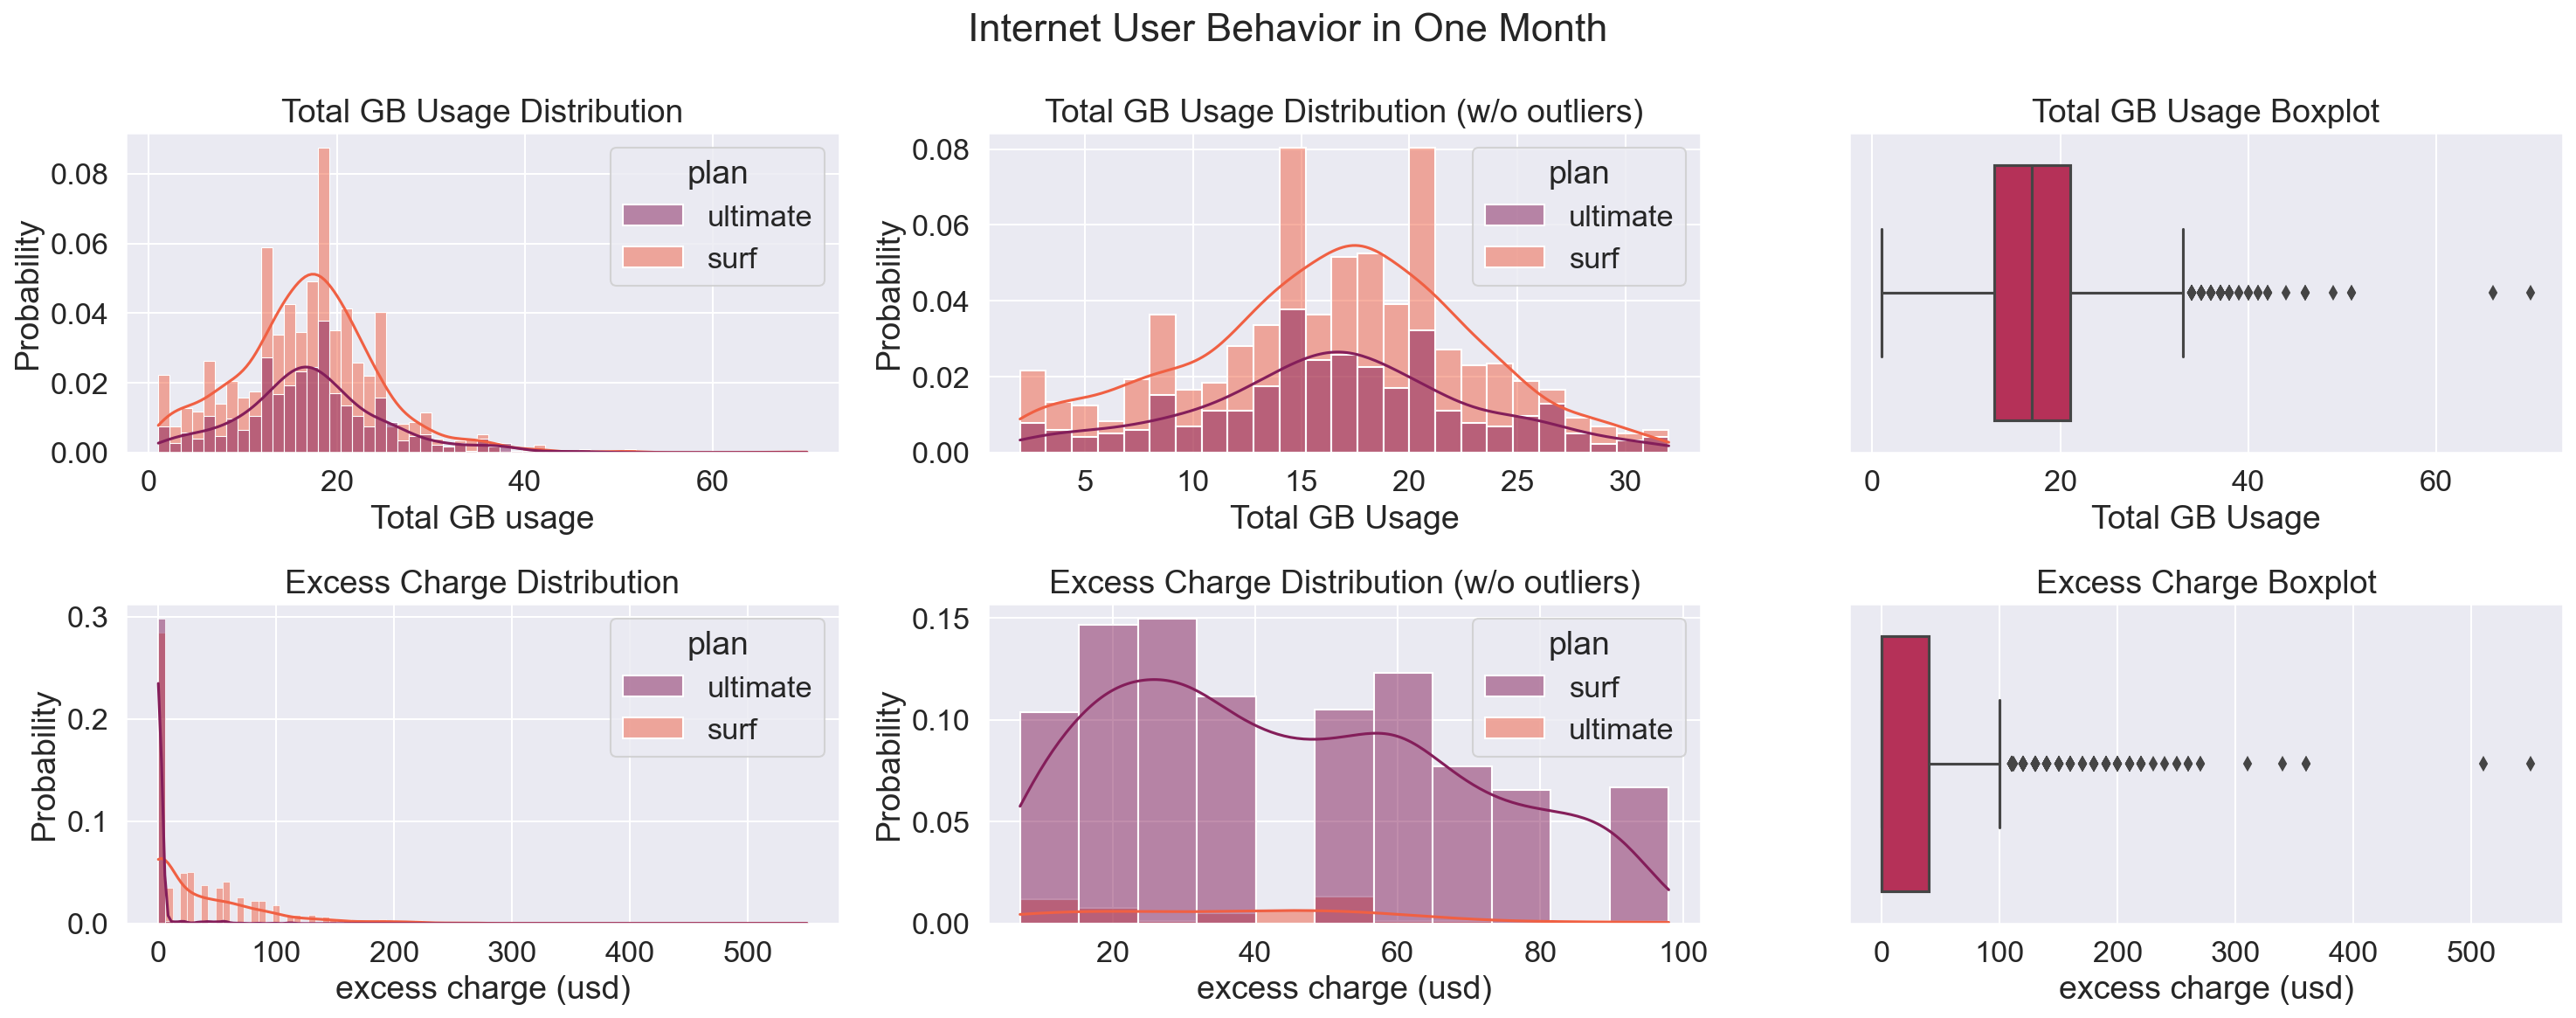

In [62]:
# create histogram
# over all distribution in internet_users

figure, axes = plt.subplots(2,3, figsize=(20,8), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Internet User Behavior in One Month')

#--------------------------------------------------------------------------------------------------------------------------------------------------
# total gb distribution
(sns.histplot(ax=axes[0,0], data=internet_user_group, x='total_gb', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Total GB Usage Distribution', xlabel='Total GB usage')
)

#------------------------------------------------
(sns.histplot(ax=axes[0,1], data=clean_total_gb, x='total_gb', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Total GB Usage Distribution (w/o outliers)', xlabel='Total GB Usage')
)

#------------------------------------------------
(sns.boxplot(ax=axes[0,2], data=internet_user_group, x='total_gb', 
              hue='plan', palette='rocket')
    .set(title='Total GB Usage Boxplot', xlabel='Total GB Usage')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# excess charge distribution
(sns.histplot(ax=axes[1,0], data=internet_user_group, x='internet_charge', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Excess Charge Distribution', xlabel='excess charge (usd)')
)

#------------------------------------------------
(sns.histplot(ax=axes[1,1], data=clean_internet_charge, x='internet_charge', hue='plan', kde=True,
              palette='rocket', stat='probability')
    .set(title='Excess Charge Distribution (w/o outliers)', xlabel='excess charge (usd)')
)

#------------------------------------------------
(sns.boxplot(ax=axes[1,2], data=internet_user_group, x='internet_charge', 
              hue='plan', palette='rocket')
    .set(title='Excess Charge Boxplot', xlabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------

 
plt.tight_layout()
plt.show()

In [63]:
plan

plan_name  usd_month  minutes_plan  usd_per_minute  msg_plan  usd_per_msg  \
0      surf         20           500            0.03        50         0.03   
1  ultimate         70          3000            0.01      1000         0.01   

   mb_plan  gb_plan  usd_per_gb  
0    15360       15          10  
1    30720       30           7

**Findings:**
- The distribution of internet usage in one month from both plans tends to have a similar pattern
- The internet usage distributions tend to be normal
- The outliers from both plans seem to have a minor influence on data distribution
- The Average and Median Data Usage is 17 GB
- The Ultimate users rarely get the excess charge, since the data usage of the majority users is far below the limit(30 GB/month)
- The Surf users tend to get excess charges around 1-10 GB/month (limit plan 15 GB/month)
- Several users (outliers) could pay the excess charge of up to 550 USD

**Insight:**
- Users in both plans tend to have similar behavior on internet usage in one month
- Compare to the call and message service, the internet service seems to gain more excess charge
- Since the majority of Internet needs from all users tend to be similar, the Surf users are most likely to cross the limit usages and pay for the extra charge

In [64]:
# categorize internet_users based plan and month
# for average and median analysis (barplot)

internet_month_group = (internet_user_group
 .groupby(['plan','month'], as_index=False)
 .agg(median_internet_charge=('internet_charge', 'median'),
      mean_internet_charge=('internet_charge', 'mean'),
      median_total_gb=('total_gb', 'median'),
      mean_total_gb=('total_gb', 'mean'))
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
internet_month_group['month'] = internet_month_group['month'].apply(lambda x: calendar.month_abbr[x])


internet_month_group.head()

month      plan  median_internet_charge  mean_internet_charge  \
0   Jan      surf                     0.0              0.000000   
1   Jan  ultimate                     0.0              0.000000   
2   Feb      surf                     0.0             13.333333   
3   Feb  ultimate                     0.0              0.000000   
4   Mar      surf                     0.0             25.217391   

   median_total_gb  mean_total_gb  
0              5.0       5.000000  
1              8.0       7.250000  
2             12.0      12.222222  
3             20.0      17.285714  
4             14.0      13.565217

In [65]:
# categorize internet_users based plan and month
# for average and median analysis (barplot)
# seperate Surf and Ultimate plan

internet_month_group_surf = (internet_month_group.query("plan=='surf'")
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
internet_month_group_surf['month'] = internet_month_group_surf['month'].apply(lambda x: calendar.month_abbr[x])


internet_month_group_ultimate = (internet_month_group.query("plan=='ultimate'")
  .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
  .set_index('month')
  .sort_index()
  .reset_index() 
 )

# replace month index from number 'int' to name 'str'
internet_month_group_ultimate['month'] = internet_month_group_ultimate['month'].apply(lambda x: calendar.month_abbr[x])


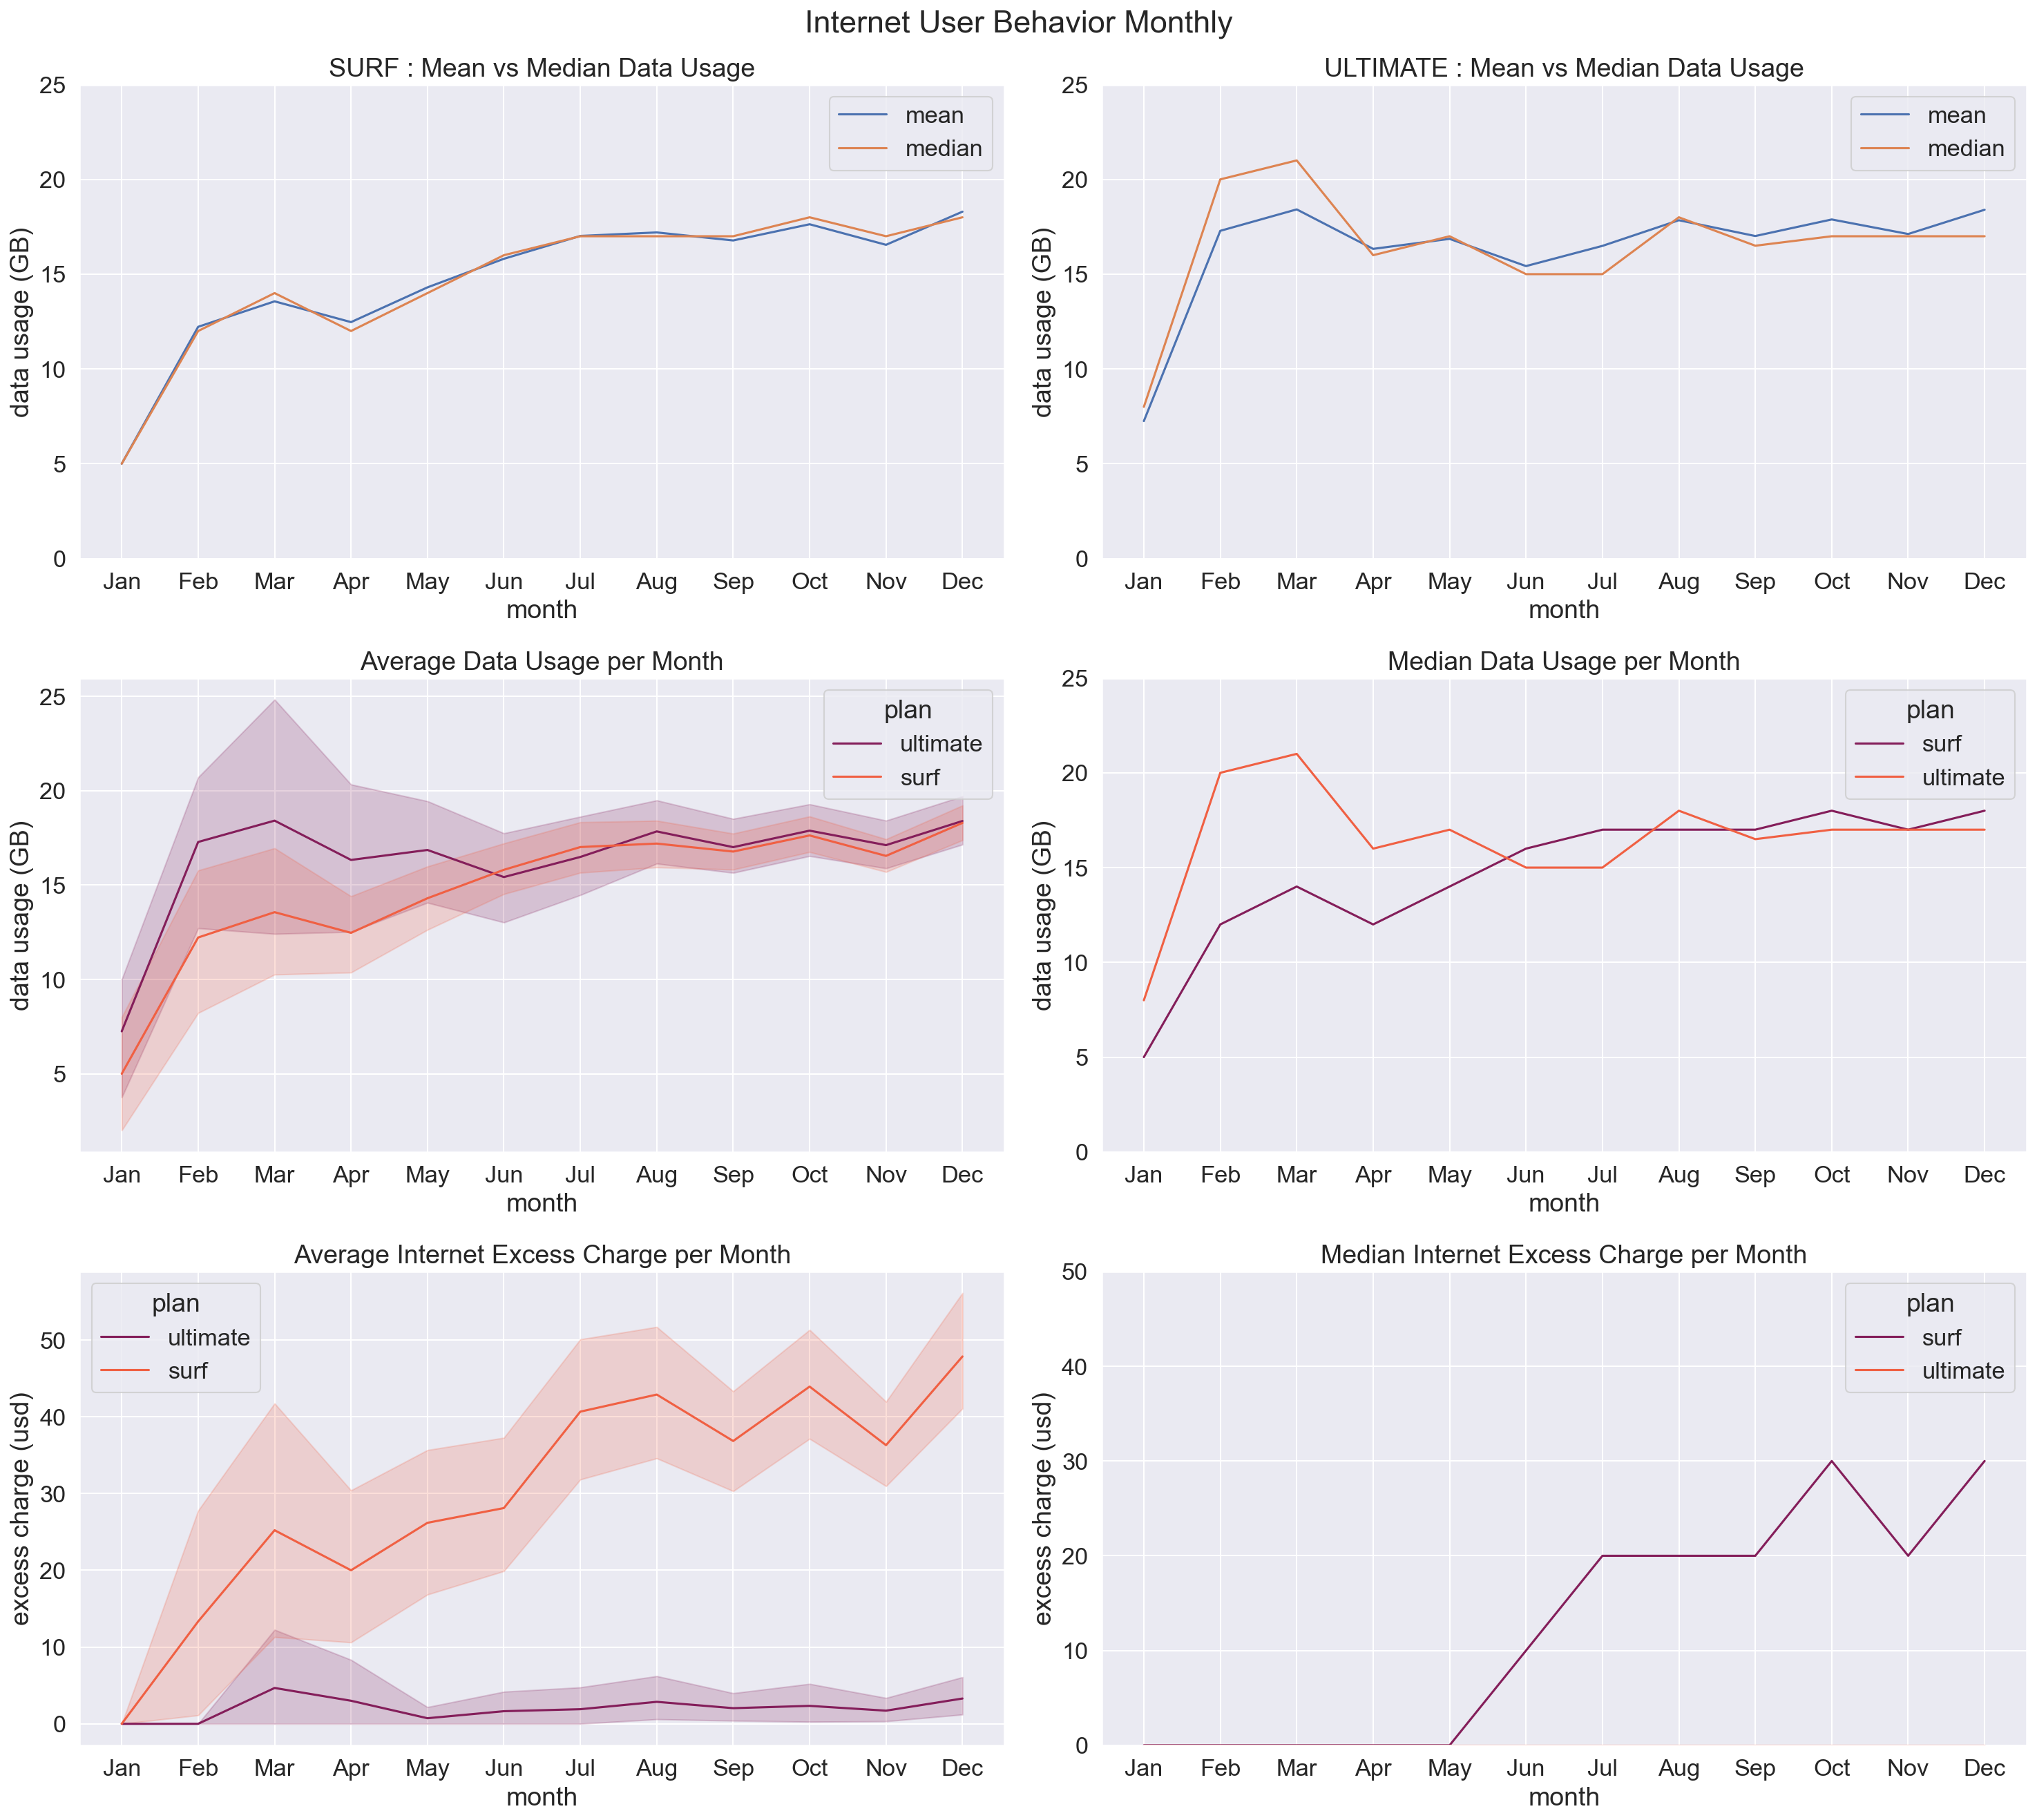

In [66]:
# create chart
# over all mean and median
figure, axes = plt.subplots(3,2, figsize=(20,18), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Internet User Behavior Monthly')


#--------------------------------------------------------------------------------------------------------------------------------------------------
# SURF: Mean and Median Gap in Total GB Usage
(sns.lineplot(ax=axes[0,0], data=internet_month_group_surf, x='month',
             y='mean_total_gb', palette='YlOrBr',
              err_style='bars', label='mean')
    .set(title='SURF : Mean vs Median Data Usage', ylim=(0,25), ylabel='data usage (GB)')
)

(sns.lineplot(ax=axes[0,0], data=internet_month_group_surf, x='month',
             y='median_total_gb', palette='Blues',
              err_style='bars', label='median')
    .set(title='SURF : Mean vs Median Data Usage', ylim=(0,25), ylabel='data usage (GB)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# ULTIMATE: Mean and Median Gap in Total GB Usage
(sns.lineplot(ax=axes[0,1], data=internet_month_group_ultimate, x='month',
             y='mean_total_gb', palette='YlOrBr', 
              err_style='bars', label='mean')
    .set(title='ULTIMATE : Mean vs Median Data Usage', ylim=(0,25), ylabel='data usage (GB)')
)

(sns.lineplot(ax=axes[0,1], data=internet_month_group_ultimate, x='month',
             y='median_total_gb', palette='Blues',
              err_style='bars', label='median')
    .set(title='ULTIMATE : Mean vs Median Data Usage', ylim=(0,25), ylabel='data usage (GB)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Total GB Usage per Month
(sns.lineplot(ax=axes[1,0], data=internet_user_group, x='month',
             y='total_gb', hue='plan', palette='rocket')
    .set(title='Average Data Usage per Month', ylabel='data usage (GB)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Median Total GB Usage per Month
(sns.lineplot(ax=axes[1,1], data=internet_month_group, x='month',
             y='median_total_gb', hue='plan', palette='rocket')
    .set(title='Median Data Usage per Month', ylim=(0,25), ylabel='data usage (GB)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Excess Charge per Month
(sns.lineplot(ax=axes[2,0], data=internet_user_group, x='month',
             y='internet_charge', hue='plan', palette='rocket')
     .set(title='Average Internet Excess Charge per Month', ylabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Median Excess Charge per Month
(sns.lineplot(ax=axes[2,1], data=internet_month_group, x='month',
             y='median_internet_charge', hue='plan', palette='rocket')
    .set(title='Median Internet Excess Charge per Month', ylim=(0,50), ylabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------


plt.tight_layout()
plt.show()

**Findings:**
- The mean and median values in internet usage from both plans tend to be similar. It's because of the normal distribution
- The average internet usage, from both plans, tends to increase gradually until July (middle term), then it started to get stable until the end of the year
- In February and March, the use of the Internet on both plans increase significantly
- The average excess charge in Surf users rise gradually until July, then stabilized until the end of the year
- The average excess charge in Ultimate users below 10 USD (1 GB/month)
- Both plan users are most likely getting no extra charge until May
- The Surf users tend to get excess charges since June
- The excess charge is around 10-30 USD (cross the limit of around 1-3 GB/month)

**Insight:**
- Users in both plans tend to have similar behavior on internet data usage (i.e average around 17 GB/month)
- The internet data usage from both plan user increase gradually until July, then it stabilizes until December
- Compared to the call and messages service, users tend to cross the internet limit plans
- We can say that users tend to use internet service usage more often than call or message service
 

**Recommendation**
- It would be better to conduct further investigation to acknowledge the reason behind the increase in internet use in the first term and the stagnancy in the second term
- We should analyze whether the patterns are affected by a particular factor(promotion, customer growth, special event, etc) or It's just an iterable pattern in one year
- We should find the reason behind the anomaly in internet data usage in February and March. Whether It is caused by a particular factor. Perhaps, Its reason might give an insight for a further strategy to increase the demand for internet usage


### Revenue

In [67]:
# decribe revenue by plan

(monthly_usage.groupby('plan')['total_revenue'].describe())

count       mean        std   min   25%    50%    75%     max
plan                                                                    
surf      1573.0  60.706408  55.388042  20.0  20.0  40.36  80.36  590.37
ultimate   720.0  72.313889  11.395108  70.0  70.0  70.00  70.00  182.00

In [68]:
# generate customized dataset for further analysis

# 1. For Excess Charge Analysis
# add column to sum total excess charge
monthly_usage['total_excess_charge'] = monthly_usage['total_revenue'] - monthly_usage['usd_month']

# 2. For distribution comparison analysis
# seperate dataset by its plan
revenue_surf = monthly_usage.query("plan=='surf'")
revenue_ultimate = monthly_usage.query("plan=='ultimate'")

# 3. For comparison original dataset to clean dataset
# remove potential outlier in total_revenue
clean_monthly_revenue = remove_outliers(monthly_usage, 'total_revenue')


# 4. For summarizing total_revenue and total excess charge analysis
total_revenue_monthly = (monthly_usage.groupby(['plan','month'])['total_revenue','total_excess_charge']
 .sum()
 .reset_index()
 .assign(month=lambda df: pd.DatetimeIndex(pd.to_datetime(df['month'], format='%b')).month)
 .set_index('month')
 .sort_index()
 .reset_index() 
)

# replace month index from number 'int' to name 'str'
total_revenue_monthly['month'] = total_revenue_monthly['month'].apply(lambda x: calendar.month_abbr[x])

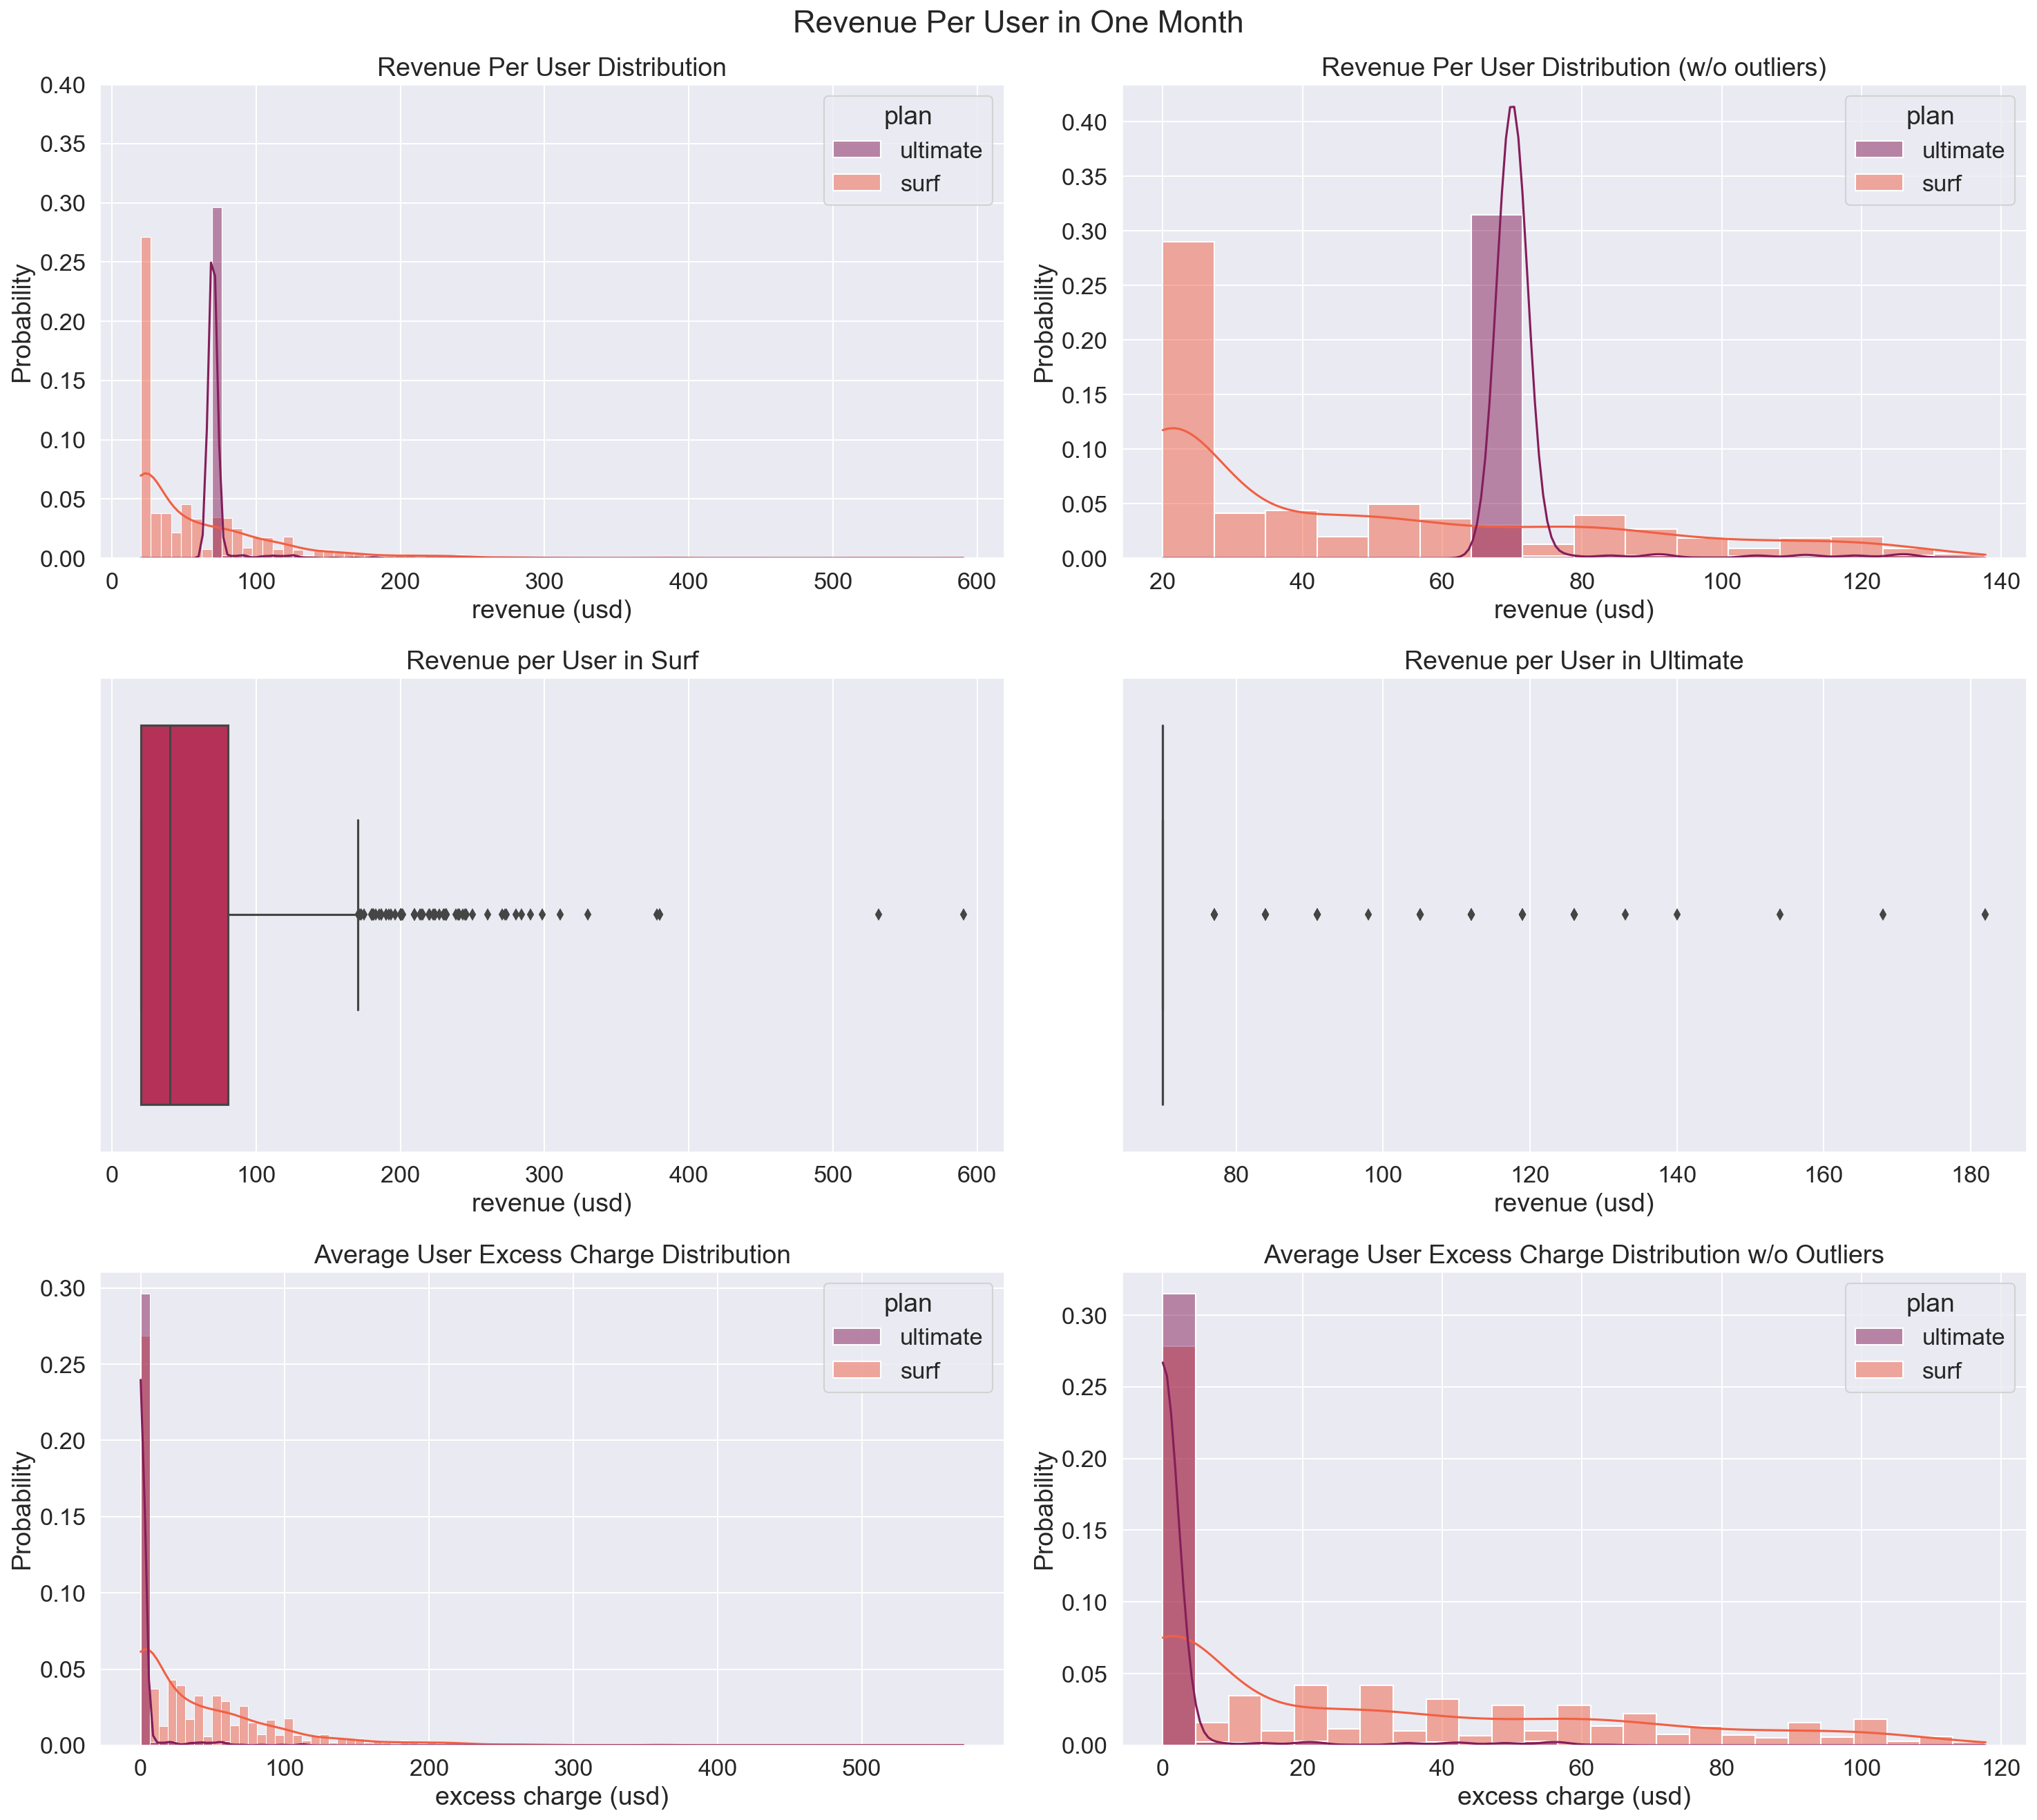

In [69]:
# create histogram
# over all distribution in total revenue

figure, axes = plt.subplots(3,2, figsize=(20,18), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Revenue Per User in One Month')

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Revenue Distribution

(sns.histplot(ax=axes[0,0], data=monthly_usage, x='total_revenue', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Revenue Per User Distribution', xlabel='revenue (usd)', ylim=(0.00, 0.40))
)

#------------------------------------------------
# Average Revenue Distribution w/o outlier

(sns.histplot(ax=axes[0,1], data=clean_monthly_revenue, x='total_revenue', hue='plan', kde=True,
              palette='rocket', stat='probability')
    .set(title='Revenue Per User Distribution (w/o outliers)', xlabel='revenue (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Boxplot :Revenue per User by plan

# SURF
(sns.boxplot(ax=axes[1,0], data=revenue_surf, x='total_revenue', 
              hue='plan', palette='rocket')
    .set(title='Revenue per User in Surf', xlabel='revenue (usd)')
)

#------------------------------------------------

# ULTIMATE
(sns.boxplot(ax=axes[1,1], data=revenue_ultimate, x='total_revenue', 
              hue='plan', palette='rocket')
    .set(title='Revenue per User in Ultimate', xlabel='revenue (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------

# Average User Excess Charge Distribution
(sns.histplot(ax=axes[2,0], data=monthly_usage, x='total_excess_charge', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Average User Excess Charge Distribution', xlabel='excess charge (usd)')
)

#------------------------------------------------
# Average User Excess Charge Distribution w/o outliers
(sns.histplot(ax=axes[2,1], data=clean_monthly_revenue, x='total_excess_charge', 
              stat='probability', hue='plan', kde=True,
              palette='rocket')
    .set(title='Average User Excess Charge Distribution w/o Outliers', xlabel='excess charge (usd)')
)

plt.tight_layout()
plt.show()

**Findings:**
- The distribution of revenue per user in one month from both plans is skewed positively
- The revenue of Surf plan distribution has long positive tailed (from 20 USD up to 600 USD)
- Mostly, the Surf plan gives revenue of 20 USD/per user
- The revenue of Ultimate plan distribution has a short positive tailed (from 70 USD up to 180 USD)
- Mostly, the Ultimate plan gives revenue of 70 USD/user
- The distribution of user excess charge in one month from both plans are skewed positively
- The user excess charge in the Surf plan has a long positive-tailed distribution (excess up to 590 USD)
- The user excess charge in the Ultimate plan has a long short-tailed distribution (excess up to 182 USD)
- The Surf users tend to pay the extra charge than the Ultimate users

**Insight:**
- Users in both plans tend to have similar behavior on service usage in one month (i.e calls, messages, and internet)
- The Surf users are most likely to pay for the extra charge than the Ultimate users

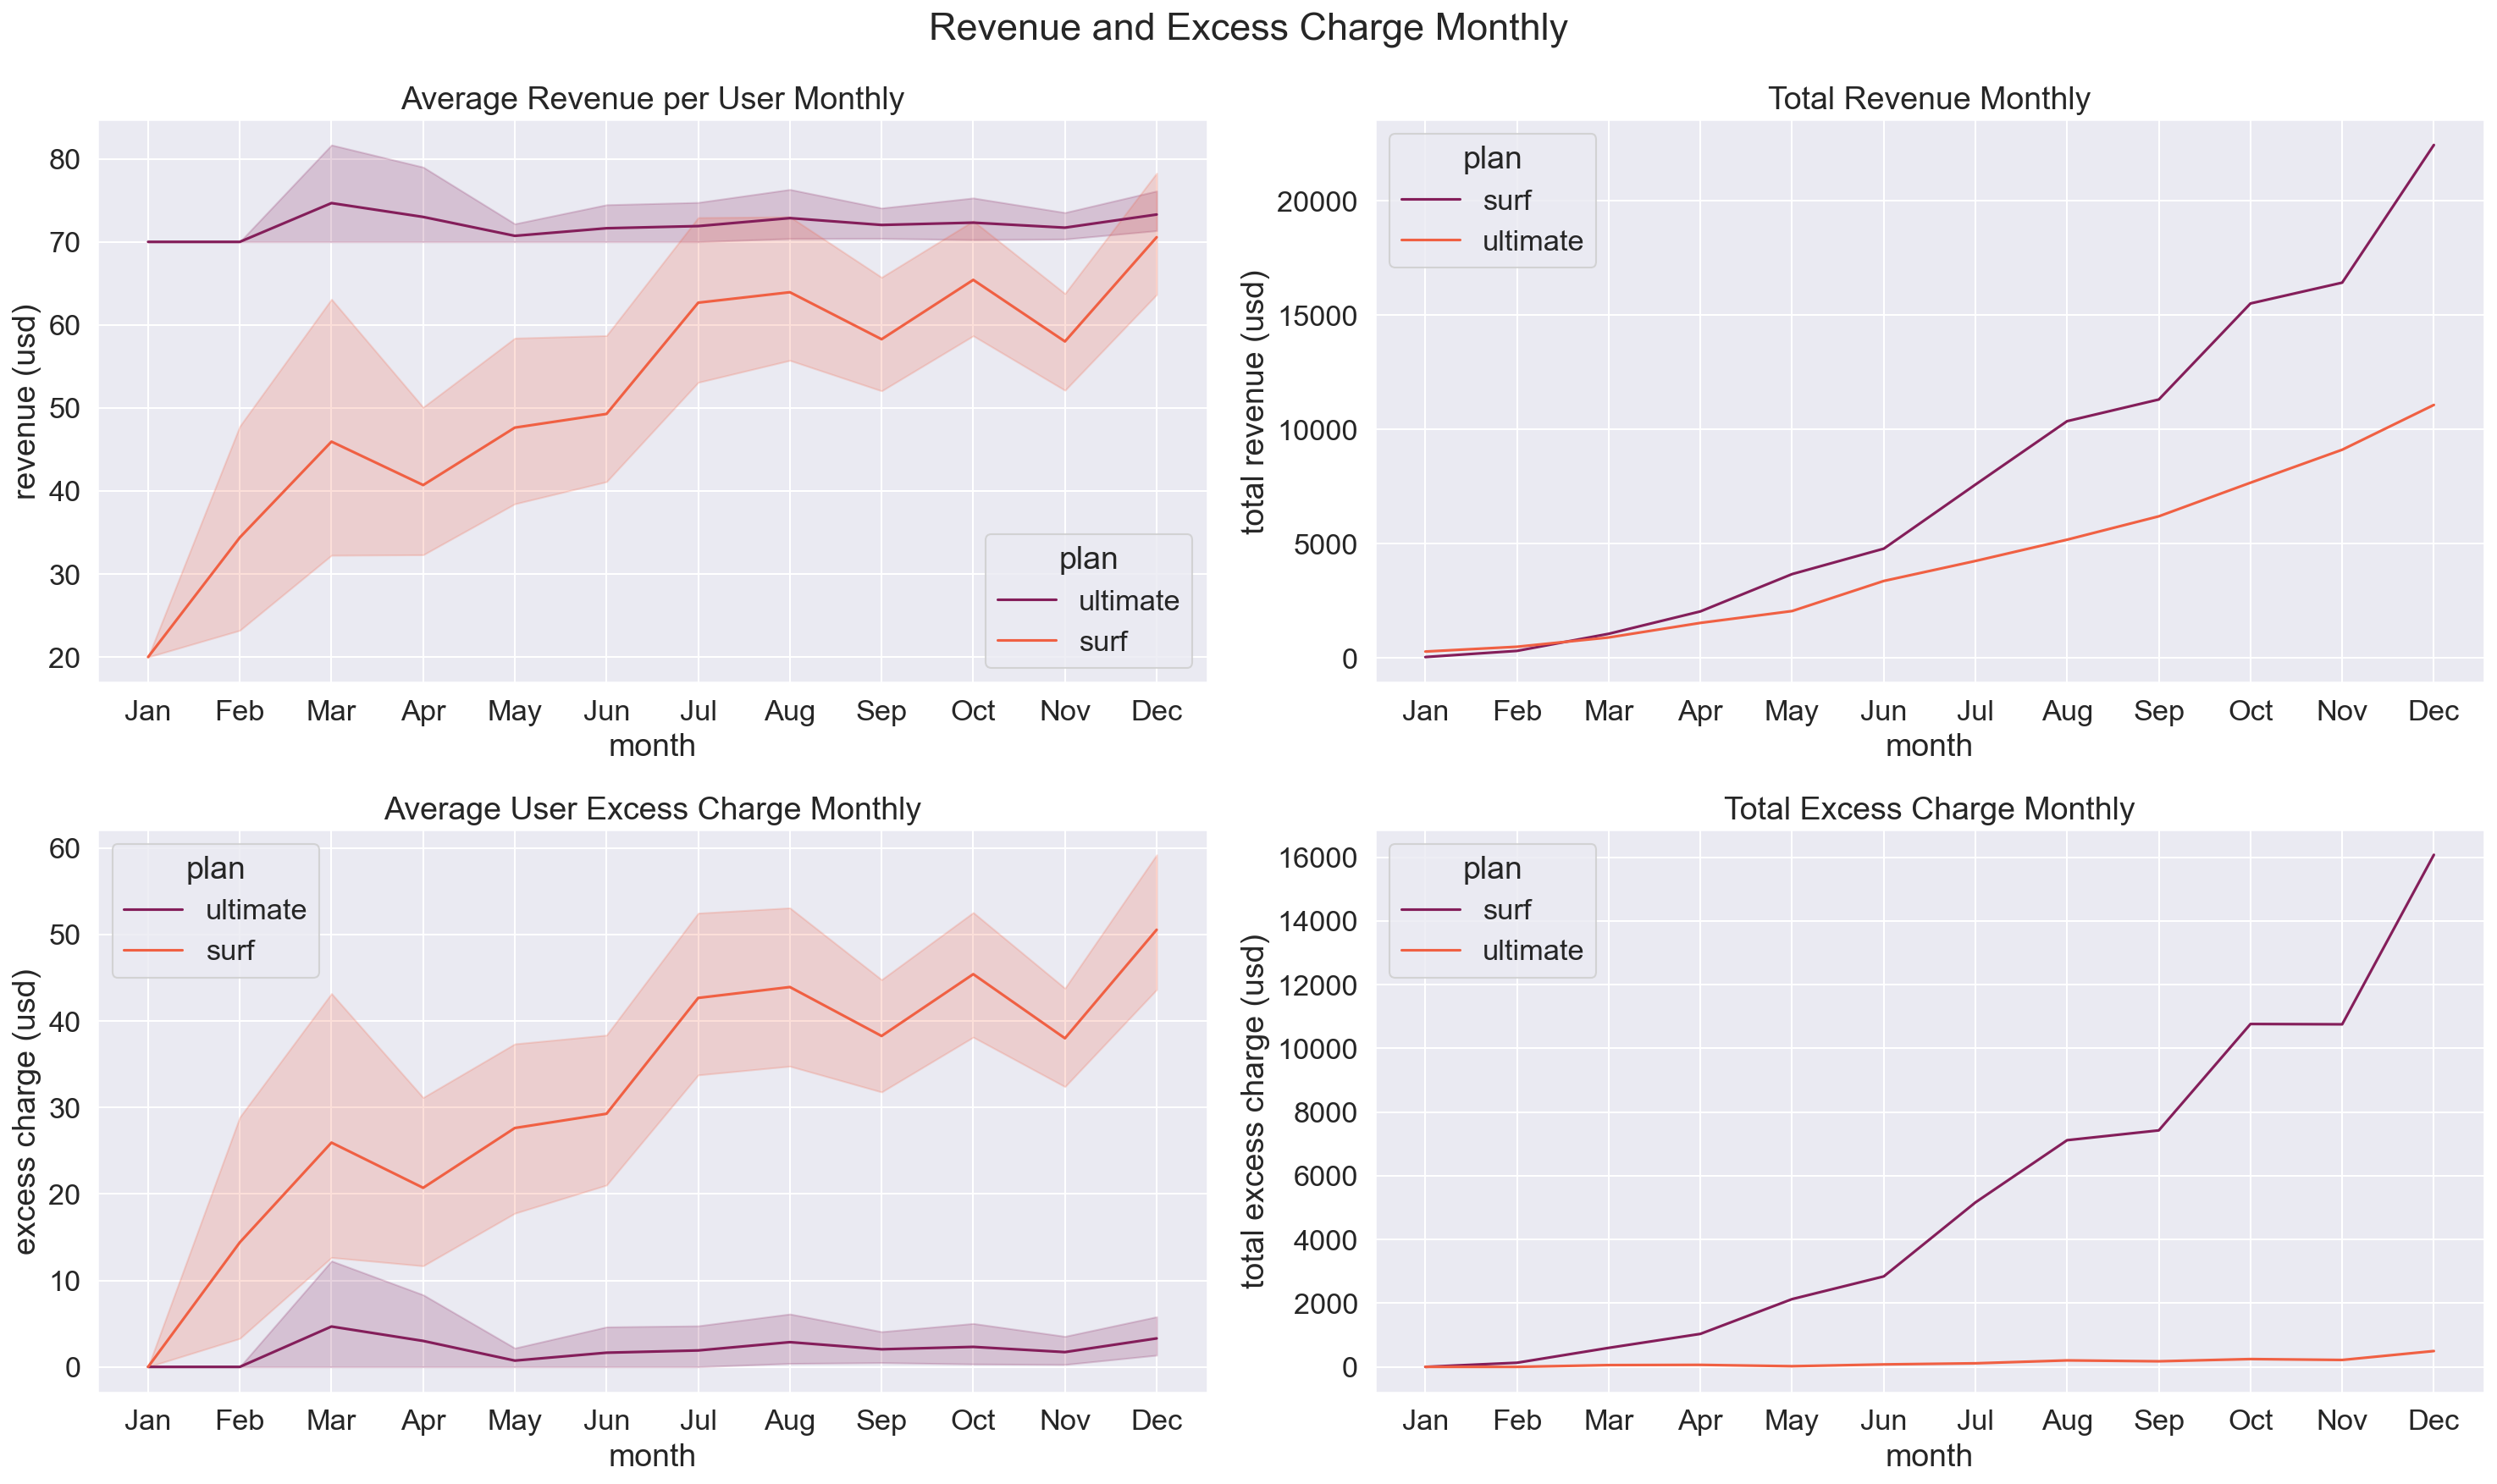

In [70]:
# create chart
# over all mean and median
figure, axes = plt.subplots(2,2, figsize=(20,12), dpi=150)
sns.set(font_scale=1.5)
figure.suptitle('Revenue and Excess Charge Monthly')


#--------------------------------------------------------------------------------------------------------------------------------------------------
# Revenue per User monthly

(sns.lineplot(ax=axes[0,0], data=monthly_usage, x='month',
             y='total_revenue', hue='plan', palette='rocket')
    .set(title='Average Revenue per User Monthly', ylabel='revenue (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Total Revenue monthly

(sns.lineplot(ax=axes[0,1], data=total_revenue_monthly, x='month',
             y='total_revenue', hue='plan', palette='rocket')
    .set(title='Total Revenue Monthly', ylabel='total revenue (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Average Excess Charge per user monthly

(sns.lineplot(ax=axes[1,0], data=monthly_usage, x='month',
             y='total_excess_charge', hue='plan', palette='rocket')
    .set(title='Average User Excess Charge Monthly', ylabel='excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Total Excess Charge monthly

(sns.lineplot(ax=axes[1,1], data=total_revenue_monthly, x='month',
             y='total_excess_charge', hue='plan', palette='rocket')
    .set(title='Total Excess Charge Monthly',ylabel='total excess charge (usd)')
)

#--------------------------------------------------------------------------------------------------------------------------------------------------


plt.tight_layout()
plt.show()

**Findings:**
- The average revenue for the Ultimate users seems to be stable during one year
- The average revenue for the Surf users tends to increase gradually during one year
- The average revenue for the Surf users almost reach the average of Ultimate revenue by December
- The total revenue for both plans rise gradually during one year
- Total revenue from the Surf plan  give two times higher than the Ultimate plan
- The average excess charge of Surf plan users rise during one year
- The average excess charge of Ultimate plan users tends to be stable from time to time

**Insight:**
- The total calls, messages, and internet service needs from all users tend to be similar
- The Ultimate plan seems to cover the majority of user needs. Most users pay the extra charge rarely
- The Surf plan users tend to pay for the extra charge since their service usage demand almost similar to the Ultimate users
- The Surf plan seems to generate higher revenue than the Ultimate plan
- Users tend to choose the cheaper plan but actually, their needs are higher than the plan limit

**Recommendation**
- It would be better to conduct further investigation to acknowledge any particular factor that affected the increase in total revenue
- We should analyze whether the patterns are affected by a particular factor(promotion, customer growth, special event, etc) or It's just an iterable pattern in one year
- We can explore any plan that potential gaining more sales and profits (i.e plan with cheap/affordable prices that cover below user needs)


## Test statistical hypotheses

### Average Revenue Comparison

- H0= The average revenue from users of the Ultimate and Surf calling plans differs
- H1= The average revenue from users of the Ultimate Plan is higher than the Surf Plan 

We will set alpha as 0.05

In [71]:
# Test the hypotheses
alpha = 0.05
results = st.ttest_ind(revenue_surf['total_revenue'], revenue_ultimate['total_revenue'])
print('The p-value is:', results.pvalue)

The p-value is: 2.862674510698644e-08


In [72]:
if (results.pvalue/2 < alpha) and (revenue_ultimate['total_revenue'].mean() > revenue_surf['total_revenue'].mean()):
    print("We reject the null hypothesis and accept the alternative hypothesis")
else:
    print("We can't reject the null hypothesis")

We reject the null hypothesis and accept the alternative hypothesis


**Interpretation:**
The average revenue for Ultimate plan is higher than the Surf Plan and gap value between both plans are different significantly

### Average Excess Charge

- H0= The average excess charge from users of the Ultimate and Surf calling plans differs
- H1= The average excess charge from users of the Surf Plan is higher than the Ultimate Plan 

We will set alpha as 0.05

In [84]:
# Test the hypotheses
alpha = 0.05
results = st.ttest_ind(revenue_surf['total_excess_charge'], revenue_ultimate['total_excess_charge'])
print('The p-value is:', results.pvalue)

if (results.pvalue/2 < alpha) and (revenue_surf['total_excess_charge'].mean() > revenue_ultimate['total_excess_charge'].mean()):
    print("We reject the null hypothesis and accept the alternative hypothesis")
else:
    print("We can't reject the null hypothesis")

The p-value is: 9.140754866524636e-71
We reject the null hypothesis and accept the alternative hypothesis


**Interpretation:**
The average excess charge for the Surf plan is higher than the Ultimate Plan and the gap value between both plans are different significantly

### Average Revenue from Users in the NY-NJ area

- H0 = The average revenue from Users in the NY-NJ area is different from that of the users from the other regions
- H1= The average revenue from Users in the NY-NJ area is greater from that of the users from the other regions

alpha = 0.05

In [79]:
# filter dataset: NY-NJ area
nynj_area = monthly_usage.query("city == 'New York-Newark-Jersey City, NY-NJ-PA MSA'")

# check the result
nynj_area['city'].unique()

array(['New York-Newark-Jersey City, NY-NJ-PA MSA'], dtype=object)

In [83]:
# filter dataset : other areas
other_areas = monthly_usage.query("~(city == 'New York-Newark-Jersey City, NY-NJ-PA MSA')")

# check the result
other_areas['city'].unique()

array(['San Francisco-Oakland-Berkeley, CA MSA',
       'Louisville/Jefferson County, KY-IN MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Denver-Aurora-Lakewood, CO MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Charlotte-Concord-Gastonia, NC-SC MSA', 'Kansas City, MO-KS MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Riverside-San Bernardino-Ontario, CA MSA',
       'Colorado Springs, CO MSA', 'Baltimore-Columbia-Towson, MD MSA',
       'Boston-Cambridge-Newton, MA-NH MSA',
       'Miami-Fort Lauderdale-West Palm Beach, FL MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'San Antonio-New Braunfels, TX MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Diego-Chula Vista-Carlsbad, CA MSA', 'Fresno, CA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Columbia, SC MSA',
       'Atlanta-Sandy Springs-Ro

In [85]:
# Test the hypotheses
alpha = 0.05
results = st.ttest_ind(nynj_area['total_revenue'], other_areas['total_revenue'])
print('The p-value is:', results.pvalue)

if (results.pvalue/2 < alpha) and (nynj_area['total_revenue'].mean() > other_areas['total_revenue'].mean()):
    print("We reject the null hypothesis and accept the alternative hypothesis")
else:
    print("We can't reject the null hypothesis")

The p-value is: 0.04355743162134274
We can't reject the null hypothesis


**Interpretation:**
The average revenue from the NY-NJ area is not different significantly than other areas.

## General conclusion
 Results from analysis users behavior
 - The Surf plan is preferable for majority of users rather than The Ultimate plan
 - During one year (2018), the number of users grew gradually
 - Both Surf and Ultimate users seem to have similar behavior
 - The service needs in calls and message increase gradually during one year (both plans)
 - The internet usage from both users' plan increase gradually until July, then stabilized until December
 - Most of the Surf plan users tend to exceed the limit plan (especially the call and internet) rather than the Ultimate plan
 
 Results from the statistical test : a comparison the average revenue from both plans and area
 - The average revenue of the Ultimate plan is higher than Surf plan statistically
 - The average excess charge of the Surf plan is higher than the Ultimate plan statistically
 - The average revenue from New York and New Jersey users (NY-NJ) are not different from users in other areas statistically  